In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn. preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# 1. Load Data
# REPLACE with your actual file
df = pd.read_csv("fmcg_sales_3years_1M_rows.csv")

print(f"📊 Initial data shape: {df.shape}")

# 2. Validate Required Columns
required_cols = ['date', 'store_id', 'sku_id', 'units_sold', 'stock_on_hand', 
                 'list_price', 'discount_pct', 'promo_flag', 'stock_out_flag']
missing_cols = [col for col in required_cols if col not in df. columns]
if missing_cols: 
    raise ValueError(f"❌ Missing required columns: {missing_cols}")
print("✅ All required columns present")

# 3. Date Conversion & Sorting (Critical for Lags)
df['date'] = pd.to_datetime(df['date'])

# Sort by store_id, sku_id, and date (critical for proper lag calculation)
df = df.sort_values(['store_id', 'sku_id', 'date']).reset_index(drop=True)

# 4. Handle Missing Values
print(f"\n🔍 Missing values per column:\n{df[required_cols].isnull().sum()}")
# Fill missing numeric values (adjust strategy as needed)
df['discount_pct'] = df['discount_pct']. fillna(0)
df['promo_flag'] = df['promo_flag'].fillna(0)

# 5. Filter Stockouts
print(f"\n📦 Rows before filtering stockouts: {len(df)}")
df = df[df['stock_out_flag'] == 0]. copy()  # Use . copy() to avoid SettingWithCopyWarning
print(f"📦 Rows after filtering stockouts: {len(df)}")
print(f"📦 Rows removed: {len(df) - len(df[df['stock_out_flag'] == 0])}")

# 6. Basic Pricing
if 'effective_price' not in df.columns:
    df['effective_price'] = df['list_price'] * (1 - df['discount_pct'])

# 7. Data Quality Checks
print(f"\n📅 Date range: {df['date'].min()} to {df['date'].max()}")
print(f"🏪 Number of stores: {df['store_id'].nunique()}")
print(f"📦 Number of SKUs: {df['sku_id'].nunique()}")
print(f"📊 Average units sold: {df['units_sold']. mean():.2f}")
print(f"💰 Average effective price: ${df['effective_price'].mean():.2f}")

print(f"\n✅ Data Loaded. Final Shape: {df.shape}")

📊 Initial data shape: (1100000, 33)
✅ All required columns present

🔍 Missing values per column:
date              0
store_id          0
sku_id            0
units_sold        0
stock_on_hand     0
list_price        0
discount_pct      0
promo_flag        0
stock_out_flag    0
dtype: int64

📦 Rows before filtering stockouts: 1100000
📦 Rows after filtering stockouts: 1066886
📦 Rows removed: 0

📅 Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00
🏪 Number of stores: 13
📦 Number of SKUs: 102
📊 Average units sold: 60.67
💰 Average effective price: $7.61

✅ Data Loaded. Final Shape: (1066886, 34)


In [2]:
import pandas as pd
import numpy as np

def engineer_features(df):
    """
    Optimized feature engineering pipeline (Fully Vectorized).
    Compatible with prepare_data_for_modeling aggregation.
    Includes: 
    - Polynomial discount features for better extrapolation
    - Product velocity and clearance features for smart pricing
    """
    # Validate required columns
    required_cols = ['date', 'store_id', 'sku_id', 'units_sold', 'stock_on_hand', 
                     'list_price', 'discount_pct', 'promo_flag', 'purchase_cost']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"❌ Missing required columns: {missing_cols}")
    
    # Make a copy to avoid modifying original
    df = df.copy()
    
    # 0. BASIC DATE PARTS
    df['date'] = pd. to_datetime(df['date'])
    df = df.sort_values(['store_id', 'sku_id', 'date']).reset_index(drop=True)
    
    df['year'] = df['date'].dt. year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    
    # FIXED: Added missing time features required by prepare_data_for_modeling
    df['weekofyear'] = df['date']. dt.isocalendar().week
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)
    df['is_holiday'] = 0  # Placeholder - replace with actual holiday calendar if available
    
    print("Starting feature engineering...")
    print(f"  Initial shape: {df.shape}")
    
    # ===================================
    # 1. TIME-BASED FEATURES
    # ===================================
    print("  📅 Creating time-based features...")
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_month_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_of_month_cos'] = np. cos(2 * np.pi * df['day'] / 31)
    df['quarter'] = df['date'].dt.quarter
    
    # ===================================
    # 2. LAG FEATURES & ROLLING STATS
    # ===================================
    print("  📊 Creating lag and rolling features...")
    grouper = df.groupby(['store_id', 'sku_id'])
    
    # Lag features
    for lag in [1, 7, 14, 30]:  
        df[f'units_sold_lag_{lag}'] = grouper['units_sold']. shift(lag)
    
    # Rolling statistics
    for window in [7, 14, 30]:  
        df[f'rolling_avg_{window}d'] = grouper['units_sold'].transform(
            lambda x: x. rolling(window, min_periods=1).mean()
        )
        df[f'rolling_std_{window}d'] = grouper['units_sold'].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
    
    df['rolling_max_7d'] = grouper['units_sold'].transform(
        lambda x: x.rolling(7, min_periods=1).max()
    )
    df['rolling_min_7d'] = grouper['units_sold'].transform(
        lambda x: x.rolling(7, min_periods=1).min()
    )

    # ===================================
    # 3. STOCK & RESTOCK
    # ===================================
    print("  📦 Creating stock and restock features...")
    df['stock_on_hand_lag_1'] = grouper['stock_on_hand'].shift(1)
    df['stock_change'] = df['stock_on_hand'] - df['stock_on_hand_lag_1']
    df['positive_stock_change'] = df['stock_change']. clip(lower=0)
    
    # Restock detection
    df['restock_flag'] = (
        (df['stock_change'] + df['units_sold_lag_1']. fillna(0)) > 10
    ).astype(int)
    
    df['estimated_restock_amount'] = np.where(
        df['restock_flag'] == 1,
        df['stock_change'] + df['units_sold_lag_1'].fillna(0),
        0
    )

    # Days since restock (Vectorized)
    df['restock_date'] = np.where(df['restock_flag'] == 1, df['date'], pd.NaT)
    df['restock_date'] = pd.to_datetime(df['restock_date'])
    df['last_restock_date'] = grouper['restock_date'].ffill()
    df['days_since_restock'] = (df['date'] - df['last_restock_date']).dt.days.fillna(999)
    
    # Restock frequency
    df['restock_frequency_7d'] = grouper['restock_flag'].transform(
        lambda x: x.rolling(7, min_periods=1).sum()
    )
    df['restock_frequency_30d'] = grouper['restock_flag'].transform(
        lambda x: x.rolling(30, min_periods=1).sum()
    )
    df['avg_restock_amount_30d'] = grouper['estimated_restock_amount'].transform(
        lambda x: x.rolling(30, min_periods=1).mean()
    )
    
    # ===================================
    # 4. PROMOTION FEATURES (🔥 ENHANCED WITH POLYNOMIAL FEATURES)
    # ===================================
    print("  🎁 Creating promotion features...")
    df['discount_amount'] = df['list_price'] * df['discount_pct']
    
    # 🔥 NEW:  Polynomial features for better extrapolation beyond training range
    print("  🔥 Adding polynomial discount features for extrapolation...")
    df['discount_pct_squared'] = df['discount_pct'] ** 2
    df['discount_pct_cubed'] = df['discount_pct'] ** 3
    df['discount_pct_sqrt'] = np.sqrt(df['discount_pct'])
    df['discount_pct_log'] = np.log1p(df['discount_pct'])  # log(1 + x)
    
    # Interaction features
    df['discount_price_interaction'] = df['discount_pct'] * df['list_price']
    
    # Check if margin_pct exists before creating interaction
    if 'margin_pct' in df.columns:
        df['discount_margin_interaction'] = df['discount_pct'] * df['margin_pct']
    else: 
        df['discount_margin_interaction'] = 0
    
    # Days since promo (Vectorized)
    df['promo_date_temp'] = np.where(df['promo_flag'] == 1, df['date'], pd. NaT)
    df['promo_date_temp'] = pd.to_datetime(df['promo_date_temp'])
    df['last_promo_date'] = grouper['promo_date_temp'].ffill()
    df['days_since_promo'] = (df['date'] - df['last_promo_date']).dt.days.fillna(999)
    
    df['promo_frequency_30d'] = grouper['promo_flag'].transform(
        lambda x: x.rolling(30, min_periods=1).sum()
    )
    
    # OPTIMIZED: Vectorized avg_discount_when_promo_30d (was VERY slow with . apply())
    df['discount_when_promo'] = df['discount_pct']. where(df['promo_flag'] == 1)
    df['avg_discount_when_promo_30d'] = grouper['discount_when_promo'].transform(
        lambda x: x.rolling(30, min_periods=1).mean()
    )
    df. drop(columns=['discount_when_promo'], inplace=True)

    # ===================================
    # 5. INVENTORY & PROFIT
    # ===================================
    print("  💰 Creating inventory and profit features...")
    safe_rolling_avg = df['rolling_avg_7d'].replace(0, 0.1)
    df['days_of_stock_remaining'] = df['stock_on_hand'] / safe_rolling_avg
    
    # NOTE: stock_to_sales_ratio uses current sales - will be excluded in modeling
    df['stock_to_sales_ratio'] = df['stock_on_hand'] / df['units_sold']. replace(0, 1)

    if 'lead_time_days' in df. columns:
        df['safety_stock_level'] = df['rolling_avg_7d'] * df['lead_time_days']
    else:
        df['safety_stock_level'] = df['rolling_avg_7d'] * 7  # Default assumption
    
    df['above_safety_stock'] = (df['stock_on_hand'] > df['safety_stock_level']).astype(int)
    
    # Stockout risk
    df['avg_days_between_restocks'] = 30 / df['restock_frequency_30d']. replace(0, 30)
    df['stockout_risk'] = (
        df['days_of_stock_remaining'] < df['avg_days_between_restocks']
    ).astype(int)
    
    # Profit metrics
    df['profit_per_unit'] = df['list_price'] * (1 - df['discount_pct']) - df['purchase_cost']
    df['total_daily_profit'] = df['units_sold'] * df['profit_per_unit']
    
    df['rolling_profit_7d'] = grouper['total_daily_profit'].transform(
        lambda x: x.rolling(7, min_periods=1).sum()
    )
    df['rolling_profit_30d'] = grouper['total_daily_profit'].transform(
        lambda x: x.rolling(30, min_periods=1).sum()
    )
    df['cost_volatility_30d'] = grouper['purchase_cost'].transform(
        lambda x: x.rolling(30, min_periods=1).std()
    )
    
    # ===================================
    # 6. WEATHER
    # ===================================
    print("  🌤️  Creating weather features...")
    if 'temperature' in df.columns:
        df['temp_cold'] = (df['temperature'] < 10).astype(int)
        df['temp_mild'] = ((df['temperature'] >= 10) & (df['temperature'] < 20)).astype(int)
        df['temp_warm'] = (df['temperature'] >= 20).astype(int)
    else:
        print("    ⚠️  Temperature column missing - using defaults")
        df['temperature'] = 15  # Default mild temperature
        df['temp_cold'] = 0
        df['temp_mild'] = 1
        df['temp_warm'] = 0

    if 'rain_mm' in df.columns:
        df['is_raining'] = (df['rain_mm'] > 0).astype(int)
        df['heavy_rain'] = (df['rain_mm'] > 5).astype(int)
    else:
        print("    ⚠️  Rain column missing - using defaults")
        df['rain_mm'] = 0
        df['is_raining'] = 0
        df['heavy_rain'] = 0
    
    # ===================================
    # 7. PRODUCT VELOCITY & CLEARANCE FEATURES (🔥 NEW)
    # ===================================
    print("  📈 Creating product velocity and clearance features...")
    
    # Calculate velocity metrics per SKU (aggregate across all stores and dates)
    sku_velocity = df.groupby('sku_id').agg({
        'units_sold': ['mean', 'std', 'sum'],
        'date': ['min', 'max']
    }).reset_index()
    
    sku_velocity. columns = ['sku_id', 'avg_daily_sales', 'sales_volatility', 
                            'total_sales', 'first_seen', 'last_seen']
    
    # Calculate days in catalog
    sku_velocity['days_in_catalog'] = (sku_velocity['last_seen'] - sku_velocity['first_seen']).dt.days + 1
    sku_velocity['sales_per_day_in_catalog'] = sku_velocity['total_sales'] / sku_velocity['days_in_catalog']
    
    # Merge back to main dataframe
    df = df.merge(sku_velocity[['sku_id', 'avg_daily_sales', 'sales_volatility', 
                                 'days_in_catalog', 'sales_per_day_in_catalog']], 
                  on='sku_id', how='left')
    
    # 🔥 VELOCITY CLASSIFICATION (using quantiles for robustness)
    velocity_thresholds = df. groupby('sku_id')['units_sold'].mean().quantile([0.25, 0.75])
    slow_threshold = velocity_thresholds.iloc[0]
    fast_threshold = velocity_thresholds.iloc[1]
    
    def classify_velocity(avg_sales):
        if avg_sales <= slow_threshold:
            return 'slow'
        elif avg_sales >= fast_threshold:
            return 'fast'
        else:  
            return 'medium'
    
    df['velocity_class'] = df['avg_daily_sales'].apply(classify_velocity)
    
    # One-hot encode velocity (for model)
    df['is_slow_moving'] = (df['velocity_class'] == 'slow').astype(int)
    df['is_medium_moving'] = (df['velocity_class'] == 'medium').astype(int)
    df['is_fast_moving'] = (df['velocity_class'] == 'fast').astype(int)
    
    velocity_map = {'slow': 0, 'medium':  1, 'fast': 2}
    df['velocity_class_encoded'] = df['velocity_class']. map(velocity_map)

    print(f"    Velocity distribution:")
    velocity_counts = df. groupby('sku_id')['velocity_class'].first().value_counts()
    for vel_class in ['fast', 'medium', 'slow']:
        count = velocity_counts. get(vel_class, 0)
        print(f"      {vel_class. capitalize()}-moving:   {count} SKUs")
    
    # 🔥 DEADSTOCK DETECTION (multiple signals)
    # Signal 1: Very low recent sales (last 30 days)
    df['recent_avg_sales_30d'] = grouper['units_sold'].transform(
        lambda x: x.rolling(30, min_periods=1).mean()
    )
    deadstock_sales_threshold = df. groupby('sku_id')['units_sold'].mean().quantile(0.10)
    
    # Signal 2: High stock relative to recent sales (overstocked)
    df['stock_to_recent_sales_ratio'] = df['stock_on_hand'] / df['recent_avg_sales_30d']. replace(0, 1)
    
    # Signal 3: Declining sales trend (last 30d vs previous 30d)
    df['prev_30d_avg'] = grouper['units_sold']. transform(
        lambda x: x.rolling(30, min_periods=1).mean().shift(30)
    )
    df['sales_trend_30d'] = df['recent_avg_sales_30d'] - df['prev_30d_avg']. fillna(df['recent_avg_sales_30d'])
    
    # 🔥 DEADSTOCK FLAG (multi-criteria)
    df['is_deadstock'] = (
        (df['recent_avg_sales_30d'] < deadstock_sales_threshold) &  # Very low sales
        (df['stock_to_recent_sales_ratio'] > 60) &  # 2+ months of stock
        (df['sales_trend_30d'] <= 0)  # Declining or flat trend
    ).astype(int)
    
    # 🔥 CLEARANCE URGENCY SCORE (0-1 scale)
    # Factors: overstocking + age + velocity
    df['days_of_excess_stock'] = np.maximum(0, df['days_of_stock_remaining'] - 30)
    df['clearance_urgency'] = np.clip(
        (df['stock_to_recent_sales_ratio'] / 100) * 0.4 +  # Overstock weight
        (df['days_in_catalog'] / 365) * 0.3 +  # Age weight
        (df['is_slow_moving']) * 0.3,  # Velocity weight
        0, 1
    )
    
    # 🔥 INVENTORY TURNOVER RATE (industry standard metric)
    df['inventory_turnover_30d'] = (df['rolling_avg_30d'] * 30) / df['stock_on_hand']. replace(0, 1)
    df['is_low_turnover'] = (df['inventory_turnover_30d'] < 2).astype(int)  # < 2x per month
    
    # 🔥 PRICE ELASTICITY PROXY (based on velocity)
    # Slow items are typically more price-sensitive
    df['estimated_elasticity'] = np.where(
        df['velocity_class'] == 'fast', -1.5,
        np.where(df['velocity_class'] == 'medium', -2.0, -2.5)
    )
    
    # 🔥 OPTIMAL DISCOUNT ZONE (based on velocity & stock)
    # Fast:  0-15%, Medium: 10-25%, Slow: 20-40%, Deadstock: 30-50%
    df['suggested_min_discount'] = np.where(
        df['is_deadstock'] == 1, 0.30,
        np.where(df['is_slow_moving'] == 1, 0.20,
                np.where(df['is_medium_moving'] == 1, 0.10, 0.0))
    )
    
    df['suggested_max_discount'] = np.where(
        df['is_deadstock'] == 1, 0.50,
        np.where(df['is_slow_moving'] == 1, 0.40,
                np.where(df['is_medium_moving'] == 1, 0.25, 0.15))
    )
    
    # 🔥 INTERACTION FEATURES (velocity × discount)
    # These help the model learn velocity-specific price responses
    df['slow_discount_interaction'] = df['is_slow_moving'] * df['discount_pct']
    df['fast_discount_interaction'] = df['is_fast_moving'] * df['discount_pct']
    df['deadstock_discount_interaction'] = df['is_deadstock'] * df['discount_pct']
    
    # Clearance urgency interactions
    df['urgency_discount_interaction'] = df['clearance_urgency'] * df['discount_pct']
    
    deadstock_count = df. groupby('sku_id')['is_deadstock'].max().sum()
    low_turnover_count = df. groupby('sku_id')['is_low_turnover']. max().sum()
    
    print(f"    Deadstock SKUs detected: {deadstock_count} ({deadstock_count/df['sku_id'].nunique()*100:.1f}%)")
    print(f"    Low turnover SKUs:  {low_turnover_count} ({low_turnover_count/df['sku_id'].nunique()*100:.1f}%)")
    
    # ===================================
    # CLEANUP
    # ===================================
    print("  🧹 Cleaning up...")
    # Fill NaN values in lag/rolling features with 0
    lag_cols = [c for c in df.columns if 'lag' in c or 'rolling' in c]
    df[lag_cols] = df[lag_cols].fillna(0)
    
    # Fill NaN in new velocity features
    df['sales_volatility'] = df['sales_volatility']. fillna(0)
    df['clearance_urgency'] = df['clearance_urgency'].fillna(0)
    df['prev_30d_avg'] = df['prev_30d_avg']. fillna(0)
    df['sales_trend_30d'] = df['sales_trend_30d'].fillna(0)
    
    # Drop temporary columns
    drop_cols = ['restock_date', 'last_restock_date', 'promo_date_temp', 
                 'last_promo_date', 'stock_on_hand_lag_1', 'prev_30d_avg']
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
    
    print(f"✅ Feature Engineering Complete.  New Shape: {df.shape}")
    print(f"  Features added: {df.shape[1] - len(required_cols)}")
    print(f"  🔥 Includes polynomial features for 30-50% discount extrapolation")
    print(f"  📈 Includes product velocity & clearance features for smart pricing")
    
    return df

In [3]:
import pandas as pd
import numpy as np

def augment_minimal_synthetic(df, elasticity_conservative=-1.8, elasticity_aggressive=-2.5):
    """
    🎯 SMART STRATEGY: Keep real data dominant, only fill critical gaps
    
    Strategy:
    1. Keep ALL real historical data (100%)
    2. Add minimal synthetic only where needed: 
       - 0-5%: Small amount for smooth transition
       - 20-25%: Boost the sparse bin
       - 30-50%: Minimal extrapolation samples
    
    Result:  ~80% real data, ~20% synthetic (not 50/50!)
    """
    
    print("="*70)
    print("SMART AUGMENTATION:  MINIMAL SYNTHETIC (80% REAL / 20% SYNTHETIC)")
    print("="*70)
    
    # Get promo data
    promo_data = df[df['promo_flag'] == 1].  copy()
    
    # Analyze current distribution
    print("\n📊 Current REAL data distribution:")
    bins = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
    bin_labels = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', 
                  '25-30%', '30-35%', '35-40%', '40-45%', '45-50%']
    
    promo_data['discount_bin'] = pd. cut(promo_data['discount_pct'], 
                                         bins=bins, labels=bin_labels, include_lowest=True)
    real_counts = promo_data['discount_bin'].value_counts().sort_index()
    total_real_promo = len(promo_data)
    
    for bin_label in bin_labels: 
        count = real_counts. get(bin_label, 0)
        pct = count / total_real_promo * 100 if total_real_promo > 0 else 0
        print(f"  {bin_label}: {count: 5,} samples ({pct: 4.1f}%) {'✅' if count > 0 else '❌'}")
    
    # Get seed data
    seed_low = promo_data[(promo_data['discount_pct'] >= 0.05) & 
                          (promo_data['discount_pct'] <= 0.15)].copy()
    seed_mid = promo_data[(promo_data['discount_pct'] >= 0.15) & 
                          (promo_data['discount_pct'] <= 0.20)].copy()
    seed_high = promo_data[(promo_data['discount_pct'] >= 0.20) & 
                           (promo_data['discount_pct'] <= 0.30)].copy()
    
    if len(seed_low) < 50 or len(seed_high) < 50:
        print("⚠️  Not enough seed data")
        return df
    
    # Pre-calculate baseline
    baseline_by_sku = df[df['promo_flag'] == 0].groupby('sku_id')['units_sold'].mean()
    avg_baseline = baseline_by_sku.mean()
    
    # 🎯 SMART STRATEGY: Only fill critical gaps
    print("\n🎯 SMART AUGMENTATION STRATEGY:")
    print("  Goal: Keep real data dominant (80%), add minimal synthetic (20%)")
    print()
    
    # Calculate average count in well-represented bins (5-20%)
    well_represented = [real_counts.get(label, 0) for label in ['5-10%', '10-15%', '15-20%', '25-30%']]
    avg_well_represented = np.mean([c for c in well_represented if c > 0])
    
    # Define MINIMAL augmentation (only where critically needed)
    discount_ranges = [
        # 🎯 0-5%: Add ~30% of average to enable smooth start (NOT full amount!)
        ('0-2%',   0.00, 0.02, int(avg_well_represented * 0.15), seed_low, -1.5),
        ('2-5%',   0.02, 0.05, int(avg_well_represented * 0.15), seed_low, -1.6),
        
        # 🎯 20-25%:  Boost sparse bin to match neighbors (NOT full uniform!)
        ('20-25%', 0.20, 0.25, max(0, int(avg_well_represented * 0.8) - real_counts.get('20-25%', 0)), 
         seed_mid if len(seed_mid) > 50 else seed_high, -1.8),
        
        # 🎯 30-50%:  Add minimal samples for extrapolation (NOT full uniform!)
        ('30-35%', 0.30, 0.35, int(avg_well_represented * 0.3), seed_high, elasticity_conservative),
        ('35-40%', 0.35, 0.40, int(avg_well_represented * 0.2), seed_high, elasticity_conservative),
        ('40-45%', 0.40, 0.45, int(avg_well_represented * 0.15), seed_high, elasticity_conservative),
        ('45-50%', 0.45, 0.50, int(avg_well_represented * 0.10), seed_high, elasticity_conservative),
    ]
    
    print("  Samples to add (minimal, strategic):")
    synthetic_samples = []
    total_synthetic = 0
    
    for range_name, discount_min, discount_max, n_samples, seed, elasticity in discount_ranges:
        
        if n_samples <= 0:
            print(f"    {range_name}: 0 (skipped)")
            continue
        
        print(f"    {range_name}: {n_samples: ,} samples")
        total_synthetic += n_samples
        
        # Sample from seed
        synth_df = seed.sample(n=n_samples, replace=True).copy()
        
        # Assign discounts
        synth_df['discount_pct'] = np.random.uniform(discount_min, discount_max, n_samples)
        
        # Map baseline
        synth_df['baseline_sales'] = synth_df['sku_id'].map(baseline_by_sku)
        missing_mask = synth_df['baseline_sales']. isna()
        if missing_mask.any():
            synth_df.loc[missing_mask, 'baseline_sales'] = (
                synth_df. loc[missing_mask, 'units_sold'] / (1 + abs(elasticity) * 0.15)
            )
        synth_df['baseline_sales'] = synth_df['baseline_sales'].replace(0, avg_baseline)
        
        # Apply elasticity
        discount_level = synth_df['discount_pct'].values
        
        if discount_max <= 0.10:
            effective_elasticity = elasticity
        elif discount_min >= 0.30:
            effective_elasticity = (
                elasticity + (elasticity_aggressive - elasticity) * np.exp(-5 * (discount_level - 0.30))
            )
        else:
            effective_elasticity = elasticity
        
        lift = np.abs(effective_elasticity) * discount_level
        synth_df['units_sold'] = synth_df['baseline_sales'] * (1 + lift)
        synth_df['units_sold'] = np.minimum(synth_df['units_sold'], synth_df['baseline_sales'] * 2.5)
        
        # Add noise
        noise = np.random.normal(1.0, 0.13, len(synth_df))
        synth_df['units_sold'] = synth_df['units_sold'] * noise
        synth_df['units_sold'] = synth_df['units_sold']. clip(lower=0)
        
        # Update features
        synth_df['discount_amount'] = synth_df['list_price'] * synth_df['discount_pct']
        synth_df['avg_discount_when_promo_30d'] = synth_df['discount_pct']
        synth_df['promo_flag'] = (synth_df['discount_pct'] > 0).astype(int)
        
        # Update polynomial features
        if 'discount_pct_squared' in synth_df.columns:
            synth_df['discount_pct_squared'] = synth_df['discount_pct'] ** 2
            synth_df['discount_pct_cubed'] = synth_df['discount_pct'] ** 3
            synth_df['discount_pct_sqrt'] = np.sqrt(synth_df['discount_pct'])
            synth_df['discount_pct_log'] = np.log1p(synth_df['discount_pct'])
            synth_df['discount_price_interaction'] = synth_df['discount_pct'] * synth_df['list_price']
            if 'margin_pct' in synth_df.columns:
                synth_df['discount_margin_interaction'] = synth_df['discount_pct'] * synth_df['margin_pct']
        
        # Update sales-derived features
        if 'gross_sales' in synth_df.columns:
            synth_df['gross_sales'] = synth_df['units_sold'] * synth_df['list_price']
        if 'net_sales' in synth_df.columns:
            synth_df['net_sales'] = synth_df['units_sold'] * synth_df['list_price'] * (1 - synth_df['discount_pct'])
        if 'total_daily_profit' in synth_df.columns and 'purchase_cost' in synth_df.columns:
            synth_df['profit_per_unit'] = synth_df['list_price'] * (1 - synth_df['discount_pct']) - synth_df['purchase_cost']
            synth_df['total_daily_profit'] = synth_df['units_sold'] * synth_df['profit_per_unit']
        
        synth_df. drop(columns=['baseline_sales'], inplace=True)
        synthetic_samples.append(synth_df)
    
    # Combine
    if synthetic_samples:
        all_synthetic = pd.concat(synthetic_samples, ignore_index=True)
    else:
        print("\n✓ No synthetic samples needed")
        return df
    
    augmented_df = pd.concat([df, all_synthetic], ignore_index=True)
    
    # Calculate final ratio
    total_promo_after = len(augmented_df[augmented_df['promo_flag'] == 1])
    synthetic_pct = (total_synthetic / total_promo_after) * 100
    real_pct = 100 - synthetic_pct
    
    print(f"\n📊 FINAL DATA COMPOSITION:")
    print(f"  Real historical data:     {total_real_promo:,} samples ({real_pct:.1f}%) ✅")
    print(f"  Synthetic augmentation:   {total_synthetic:,} samples ({synthetic_pct:.1f}%)")
    print(f"  Total promo data:        {total_promo_after: ,} samples")
    print(f"\n  ✅ Model will learn primarily from REAL data!")
    
    # Show final distribution
    print("\n📊 Final distribution:")
    final_promo = augmented_df[augmented_df['promo_flag'] == 1]. copy()
    final_promo['discount_bin'] = pd.cut(final_promo['discount_pct'], bins=bins, labels=bin_labels, include_lowest=True)
    final_counts = final_promo['discount_bin'].value_counts().sort_index()
    
    for bin_label in bin_labels:
        count = final_counts.get(bin_label, 0)
        pct = count / len(final_promo) * 100
        real = real_counts.get(bin_label, 0)
        synthetic = count - real
        print(f"  {bin_label}: {count: 5,} ({pct: 4.1f}%) [Real: {real:4,}, Synthetic: {synthetic: 4,}]")
    
    print(f"\n✓ Augmented dataset: {len(df):,} → {len(augmented_df):,} rows (+{len(all_synthetic):,})")
    print("="*70)
    
    return augmented_df

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta

def prepare_data_for_modeling(df_engineered, test_size_days=30, val_size_days=30, unified_model=True):
    """
    Prepare engineered data for demand forecasting models
    
    Parameters:
    -----------
    df_engineered :  DataFrame
        Output from engineer_features() function
    test_size_days : int
        Number of days to use for test set (most recent data)
    val_size_days : int
        Number of days to use for validation set
    unified_model : bool
        If True, prepares data for single unified model (recommended)
        If False, prepares separate baseline + promotion datasets (legacy)
    
    Returns:
    --------
    dict containing all prepared datasets and encoders
    """
    
    df = df_engineered.copy()
    print("="*70)
    print("DATA PREPARATION FOR MODELING")
    print("="*70)
    print(f"Mode: {'UNIFIED MODEL' if unified_model else 'SEPARATE MODELS (Legacy)'}")
    print(f"\nInitial data shape: {df.shape}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Total days: {(df['date'].max() - df['date'].min()).days + 1}")
    print(f"Number of stores: {df['store_id']. nunique()}")
    print(f"Number of SKUs: {df['sku_id'].nunique()}")
    
    # ===================================
    # 1. AGGREGATE BY DATE AND SKU (Across Stores)
    # ===================================
    print("\n" + "-"*70)
    print("STEP 1: Aggregating across stores (daily total per SKU)")
    print("-"*70)
    
    # Build aggregation dict dynamically based on available columns
    agg_dict = {
        # Core identifiers (take first)
        'year': 'first',
        'month':   'first',
        'day':  'first',
        'weekofyear': 'first',
        'weekday': 'first',
        'is_weekend': 'first',
        'is_holiday': 'first',
        
        # Core sales metrics (SUM across stores)
        'units_sold': 'sum',
        
        # Price/discount (average - should be consistent)
        'list_price': 'mean',
        'discount_pct': 'mean',
        'promo_flag': 'max',  # 1 if ANY store had promo
        
        # Stock (SUM across stores)
        'stock_on_hand': 'sum',
        'stock_out_flag': 'max',
        
        # Supply chain (average)
        'purchase_cost': 'mean',
        
        # Time features (first - same for all stores)
        'day_of_week_sin': 'first',
        'day_of_week_cos':  'first',
        'month_sin': 'first',
        'month_cos': 'first',
        'day_of_month_sin': 'first',
        'day_of_month_cos': 'first',
        'quarter':   'first',
    }
    
    # Add optional columns if they exist
    # Add optional columns if they exist
    optional_cols = {
        'temperature': 'mean',
        'rain_mm': 'mean',
        'gross_sales': 'sum',
        'net_sales':    'sum',
        'lead_time_days': 'mean',
        'margin_pct': 'mean',
        'sku_name': 'first',
        'category': 'first',
        'subcategory': 'first',
        'brand': 'first',
        # 🔥 ADD THESE VELOCITY FEATURES: 
        'velocity_class': 'first',  # Categorical - take first value
        'is_slow_moving': 'max',
        'is_medium_moving': 'max',
        'is_fast_moving': 'max',
        'avg_daily_sales': 'mean',
        'sales_volatility': 'mean',
        'days_in_catalog': 'first',
        'sales_per_day_in_catalog': 'mean',
        'recent_avg_sales_30d': 'mean',
        'stock_to_recent_sales_ratio': 'mean',
        'sales_trend_30d': 'mean',
        'is_deadstock': 'max',
        'clearance_urgency': 'mean',
        'days_of_excess_stock': 'mean',
        'inventory_turnover_30d': 'mean',
        'is_low_turnover': 'max',
        'estimated_elasticity': 'first',
        'suggested_min_discount': 'first',
        'suggested_max_discount': 'first',
    }
    
    for col, agg_func in optional_cols.items():
        if col in df. columns:
            agg_dict[col] = agg_func
    
    # Add engineered features (excluding lag/rolling - we'll recalculate those)
    feature_cols = {
        # Stock features
        'restock_flag': 'max',
        'estimated_restock_amount': 'sum',
        'days_since_restock': 'mean',
        'restock_frequency_7d': 'sum',
        'restock_frequency_30d': 'sum',
        'avg_restock_amount_30d': 'mean',
        
        # Inventory adequacy
        'safety_stock_level': 'sum',
        'above_safety_stock': 'mean',
        'avg_days_between_restocks': 'mean',
        'stockout_risk':   'max',
        
        # Profit metrics
        'profit_per_unit': 'mean',
        'total_daily_profit': 'sum',
        'cost_volatility_30d': 'mean',
        
        # Promotion features
        'discount_amount': 'mean',
        'days_since_promo': 'mean',
        'promo_frequency_30d': 'sum',
        'avg_discount_when_promo_30d':   'mean',
        
        # Weather
        'temp_cold':  'max',
        'temp_mild':   'max',
        'temp_warm':  'max',
        'is_raining': 'max',
        'heavy_rain':  'max',

        # 🔥 ADD VELOCITY INTERACTION FEATURES:
        'slow_discount_interaction': 'mean',
        'fast_discount_interaction': 'mean',
        'deadstock_discount_interaction': 'mean',
        'urgency_discount_interaction': 'mean',
    }
    
    for col, agg_func in feature_cols.items():
        if col in df.columns:
            agg_dict[col] = agg_func
    
    # Aggregate by date and SKU
    df_agg = df.groupby(['date', 'sku_id'], as_index=False).agg(agg_dict)
    
    print(f"After aggregation shape: {df_agg.shape}")
    print(f"Stores aggregated: ✓ ({df['store_id'].nunique()} stores)")
    
    # ===================================
    # 1.5. RECALCULATE LAG & ROLLING FEATURES
    # ===================================
    print("\n" + "-"*70)
    print("STEP 1.5: Recalculating lag and rolling features on aggregated data")
    print("-"*70)
    print("  ⚠️  Store-level lags were summed, now recalculating for total demand")
    
    # Sort by SKU and date
    df_agg = df_agg.sort_values(['sku_id', 'date']).reset_index(drop=True)
    grouper_agg = df_agg. groupby('sku_id')
    
    # Lag features
    for lag in [1, 7, 14, 30]: 
        df_agg[f'units_sold_lag_{lag}'] = grouper_agg['units_sold'].shift(lag)
    
    # Rolling statistics
    for window in [7, 14, 30]: 
        df_agg[f'rolling_avg_{window}d'] = grouper_agg['units_sold'].transform(
            lambda x: x. rolling(window, min_periods=1).mean()
        )
        df_agg[f'rolling_std_{window}d'] = grouper_agg['units_sold'].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
    
    df_agg['rolling_max_7d'] = grouper_agg['units_sold'].transform(
        lambda x: x.rolling(7, min_periods=1).max()
    )
    df_agg['rolling_min_7d'] = grouper_agg['units_sold'].transform(
        lambda x: x.rolling(7, min_periods=1).min()
    )
    
    # Rolling profit (if profit exists)
    if 'total_daily_profit' in df_agg.columns:
        df_agg['rolling_profit_7d'] = grouper_agg['total_daily_profit']. transform(
            lambda x: x.rolling(7, min_periods=1).sum()
        )
        df_agg['rolling_profit_30d'] = grouper_agg['total_daily_profit'].transform(
            lambda x: x. rolling(30, min_periods=1).sum()
        )
    
    # Fill NaN in lag/rolling features
    lag_rolling_cols = [c for c in df_agg. columns if 'lag' in c or 'rolling' in c]
    df_agg[lag_rolling_cols] = df_agg[lag_rolling_cols].fillna(0)
    
    print(f"  ✓ Recalculated {len(lag_rolling_cols)} lag/rolling features")
    
    # ===================================
    # 2. HANDLE CATEGORICAL ENCODING
    # ===================================
    print("\n" + "-"*70)
    print("STEP 2: Encoding categorical variables")
    print("-"*70)
    
    # Identify categorical columns that exist
    categorical_cols = ['sku_id']
    optional_cats = ['category', 'subcategory', 'brand', 'sku_name']
    for col in optional_cats:
        if col in df_agg. columns:
            categorical_cols. append(col)
    
    # Create label encoders
    encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_agg[f'{col}_encoded'] = le.fit_transform(df_agg[col]. astype(str))
        encoders[col] = le
        print(f"  {col}: {df_agg[col].nunique()} unique values encoded")
    
    # ===================================
    # 3. TIME-BASED SPLIT
    # ===================================
    print("\n" + "-"*70)
    print("STEP 3: Time-based train/val/test split")
    print("-"*70)
    
    # Get date boundaries (fixed off-by-one)
    max_date = df_agg['date'].max()
    test_start_date = max_date - timedelta(days=test_size_days - 1)
    val_start_date = test_start_date - timedelta(days=val_size_days)
    
    print(f"\nSplit dates:")
    print(f"  Training:     {df_agg['date']. min()} to {val_start_date - timedelta(days=1)}")
    print(f"  Validation:  {val_start_date} to {test_start_date - timedelta(days=1)}")
    print(f"  Test:       {test_start_date} to {max_date}")
    
    # Create splits
    train_data = df_agg[df_agg['date'] < val_start_date]. copy()
    val_data = df_agg[(df_agg['date'] >= val_start_date) & (df_agg['date'] < test_start_date)].copy()
    test_data = df_agg[df_agg['date'] >= test_start_date].copy()
    
    print(f"\nSplit sizes:")
    print(f"  Train:  {len(train_data)} rows ({len(train_data)/len(df_agg)*100:.1f}%)")
    print(f"  Val:   {len(val_data)} rows ({len(val_data)/len(df_agg)*100:.1f}%)")
    print(f"  Test:  {len(test_data)} rows ({len(test_data)/len(df_agg)*100:.1f}%)")
    
    # ===================================
    # 4. ANALYZE DISCOUNT DISTRIBUTION (🔥 NEW - Important for Unified Model)
    # ===================================
    print("\n" + "-"*70)
    print("STEP 4: Analyzing discount distribution")
    print("-"*70)
    
    # Check promotion ratio
    promo_ratio = train_data['promo_flag']. mean()
    print(f"\nPromotion ratio in training data: {promo_ratio*100:.1f}%")
    
    if promo_ratio < 0.05:
        print("  ⚠️  WARNING: Very few promotional periods in data (<5%)")
        print("  Consider using industry benchmarks or elasticity estimates")
    
    # Show discount distribution
    promo_data = train_data[train_data['promo_flag'] == 1]
    if len(promo_data) > 0:
        print(f"\nDiscount distribution (promo periods only):")
        discount_bins = pd.cut(promo_data['discount_pct'], 
                               bins=[0, 0.05, 0.10, 0.15, 0.20, 0.30, 0.50, 1.0],
                               labels=['0-5%', '5-10%', '10-15%', '15-20%', '20-30%', '30-50%', '50%+'])
        discount_counts = discount_bins.value_counts(normalize=True).sort_index()
        for bin_label, pct in discount_counts.items():
            print(f"  {bin_label}: {pct*100:.1f}% of promos")
        
        # Warning if data is imbalanced
        if discount_counts.max() > 0.7:
            print("\n  ⚠️  WARNING: Discount distribution is imbalanced")
            print("  Model may not learn well for underrepresented discount levels")
    
    # ===================================
    # 5. SPLIT INTO BASELINE vs UNIFIED DATA
    # ===================================
    print("\n" + "-"*70)
    if unified_model:
        print("STEP 5: Preparing unified model dataset (ALL data)")
    else:
        print("STEP 5: Separating baseline (no promo) vs promotion data (Legacy)")
    print("-"*70)
    
    # BASELINE DATA:  Only non-promotional periods (promo_flag = 0)
    # (Still useful for analysis even with unified model)
    baseline_train = train_data[train_data['promo_flag'] == 0]. copy()
    baseline_val = val_data[val_data['promo_flag'] == 0].copy()
    baseline_test = test_data[test_data['promo_flag'] == 0].copy()
    
    # UNIFIED/PROMOTION DATA: ALL data (both promo and non-promo)
    unified_train = train_data. copy()
    unified_val = val_data.copy()
    unified_test = test_data. copy()
    
    if unified_model:
        print(f"\nUnified model dataset (recommended):")
        print(f"  Train: {len(unified_train)} rows")
        print(f"    - With promotions:     {int(unified_train['promo_flag']. sum())} ({unified_train['promo_flag'].mean()*100:.1f}%)")
        print(f"    - Without promotions: {int((unified_train['promo_flag']==0).sum())} ({(1-unified_train['promo_flag']. mean())*100:.1f}%)")
        print(f"  Val:   {len(unified_val)} rows ({int(unified_val['promo_flag'].sum())} with promos)")
        print(f"  Test:  {len(unified_test)} rows ({int(unified_test['promo_flag'].sum())} with promos)")
    else:
        print(f"\nBaseline model data (promo_flag = 0 only):")
        print(f"  Train: {len(baseline_train)} rows")
        print(f"  Val:   {len(baseline_val)} rows")
        print(f"  Test:  {len(baseline_test)} rows")
        
        print(f"\nPromotion model data (all data):")
        print(f"  Train: {len(unified_train)} rows ({int(unified_train['promo_flag'].sum())} with promos)")
        print(f"  Val:   {len(unified_val)} rows ({int(unified_val['promo_flag'].sum())} with promos)")
        print(f"  Test:  {len(unified_test)} rows ({int(unified_test['promo_flag'].sum())} with promos)")
    
    # ===================================
    # 6. DEFINE FEATURE COLUMNS
    # ===================================
    print("\n" + "-"*70)
    print("STEP 6: Defining feature sets")
    print("-"*70)
    
    # Columns to ALWAYS exclude (identifiers, targets, leakage)
    exclude_cols = [
        'date', 'year', 'month', 'day',
        'sku_id', 'units_sold',  # Target
    ]
    
    # Add optional columns to exclude if they exist
    optional_exclude = [
        'sku_name', 'category', 'subcategory', 'brand',  # Use encoded versions
        'gross_sales', 'net_sales', 'total_daily_profit',  # Derived from target
        'stock_out_flag',  # Filtered out already
        'stock_change', 'positive_stock_change',  # Data leakage
        'days_of_stock_remaining', 'stock_to_sales_ratio',  # Data leakage
        'velocity_class'
    ]
    
    for col in optional_exclude:
        if col in df_agg. columns:
            exclude_cols. append(col)
    
    # BASELINE FEATURES:  Exclude promotion features (for legacy support)
    # BASELINE FEATURES:  Exclude promotion features (for legacy support)
    baseline_exclude = exclude_cols + [
        'promo_flag', 'discount_pct', 'discount_amount',
        'days_since_promo', 'promo_frequency_30d', 'avg_discount_when_promo_30d',
        # 🔥 ALSO exclude polynomial discount features
        'discount_pct_squared', 'discount_pct_cubed', 'discount_pct_sqrt',
        'discount_pct_log', 'discount_price_interaction', 'discount_margin_interaction'
    ]
    
    baseline_features = [col for col in baseline_train.columns 
                        if col not in baseline_exclude]
    
    # UNIFIED/PROMOTION FEATURES:  Include ALL features including promotion
    unified_features = [col for col in unified_train.columns 
                       if col not in exclude_cols]
    
    print(f"\nBaseline model features:  {len(baseline_features)} features")
    print(f"  (excludes promotion-related features)")
    
    if unified_model:
        print(f"\nUnified model features:  {len(unified_features)} features")
        print(f"  (includes ALL features:  discount_pct, promo_flag, etc.)")
        print(f"  ✅ This allows smooth predictions from 0% to 50% discount")
    else:
        print(f"\nPromotion model features: {len(unified_features)} features")
        print(f"  (includes promotion features:  discount_pct, promo_flag, etc.)")
    
    # ===================================
    # 7. CREATE FINAL DATASETS
    # ===================================
    print("\n" + "-"*70)
    print("STEP 7: Creating final X and y datasets")
    print("-"*70)
    
    target = 'units_sold'
    
    # BASELINE MODEL DATASETS (for legacy support or comparison)
    X_baseline_train = baseline_train[baseline_features]
    y_baseline_train = baseline_train[target]
    
    X_baseline_val = baseline_val[baseline_features]
    y_baseline_val = baseline_val[target]
    
    X_baseline_test = baseline_test[baseline_features]
    y_baseline_test = baseline_test[target]
    
    # UNIFIED MODEL DATASETS
    X_unified_train = unified_train[unified_features]
    y_unified_train = unified_train[target]
    
    X_unified_val = unified_val[unified_features]
    y_unified_val = unified_val[target]
    
    X_unified_test = unified_test[unified_features]
    y_unified_test = unified_test[target]
    
    print("\n✓ Datasets created successfully!")
    
    # ===================================
    # 8. INDUSTRY BENCHMARK ELASTICITY
    # ===================================
    print("\n" + "-"*70)
    print("STEP 8: Industry benchmark elasticity (fallback)")
    print("-"*70)
    
    industry_elasticity = {
        'Personal Care': -2.0,
        'Food':  -1.5,
        'Beverages': -2.5,
        'Household': -1.8,
        'Default': -2.0
    }
    
    print("\nIndustry elasticity benchmarks:")
    for category, elasticity in industry_elasticity.items():
        print(f"  {category}: {elasticity}")
        print(f"    → 10% discount = {abs(elasticity)*10:.0f}% sales increase")
        print(f"    → 20% discount = {abs(elasticity)*20:.0f}% sales increase")
    
    # ===================================
    # 9. PREPARE RETURN PACKAGE
    # ===================================
    
    data_package = {
        'df_aggregated': df_agg,
        
        # Baseline model data (legacy support)
        'baseline':  {
            'X_train': X_baseline_train,
            'y_train': y_baseline_train,
            'X_val': X_baseline_val,
            'y_val':  y_baseline_val,
            'X_test': X_baseline_test,
            'y_test': y_baseline_test,
            'features': baseline_features,
            'train_data': baseline_train,
            'val_data': baseline_val,
            'test_data': baseline_test,
        },
        
        # Unified/Promotion model data (recommended)
        'promotion': {
            'X_train': X_unified_train,
            'y_train': y_unified_train,
            'X_val': X_unified_val,
            'y_val':  y_unified_val,
            'X_test': X_unified_test,
            'y_test': y_unified_test,
            'features': unified_features,
            'train_data':  unified_train,
            'val_data': unified_val,
            'test_data': unified_test,
        },
        
        'encoders': encoders,
        'industry_elasticity': industry_elasticity,
        
        'metadata': {
            'target': target,
            'test_start_date': test_start_date,
            'val_start_date': val_start_date,
            'max_date': max_date,
            'n_stores_aggregated': df['store_id'].nunique(),
            'n_skus':  df_agg['sku_id']. nunique(),
            'promo_ratio': promo_ratio,
            'unified_model': unified_model,
        }
    }
    
    print("\n" + "="*70)
    print("DATA PREPARATION COMPLETE!")
    print("="*70)
    
    if unified_model:
        print("\n✅ Data prepared for UNIFIED MODEL approach")
        print("   Use data['promotion'] for training unified_model")
        print("\nRecommended usage:")
        print("  unified_model = train_unified_model(data, model_type='lightgbm')")
    else:
        print("\n⚠️  Data prepared for LEGACY dual-model approach")
        print("   Consider using unified_model=True for better results")
    
    print("\nAccess data using:")
    print("  data['promotion']['X_train']  - Unified model training features (recommended)")
    print("  data['promotion']['y_train']  - Unified model training target")
    print("  data['baseline']['X_train']   - Baseline model features (legacy)")
    print("  data['encoders']              - Label encoders for categorical vars")
    print("  data['industry_elasticity']   - Fallback elasticity benchmarks")
    print("  data['metadata']              - Dataset metadata")
    
    return data_package


# ===================================
# HELPER FUNCTION:  Apply Industry Elasticity
# ===================================
def apply_industry_elasticity(baseline_forecast, discount_pct, category='Default', 
                               elasticity_dict=None):
    """
    Apply industry elasticity benchmark to baseline forecast
    
    Parameters:
    -----------
    baseline_forecast : float or array
        Predicted units sold without promotion
    discount_pct : float
        Discount percentage (0.0 to 1.0, e.g., 0.10 for 10%)
    category : str
        Product category for elasticity lookup
    elasticity_dict : dict
        Custom elasticity values by category
    
    Returns:
    --------
    promo_forecast :  Predicted units sold with promotion
    lift_pct : Percentage increase in sales
    """
    
    if elasticity_dict is None: 
        elasticity_dict = {
            'Personal Care': -2.0,
            'Food': -1.5,
            'Beverages': -2.5,
            'Household': -1.8,
            'Default':  -2.0
        }
    
    elasticity = elasticity_dict.get(category, elasticity_dict['Default'])
    lift_pct = abs(elasticity) * discount_pct
    promo_forecast = baseline_forecast * (1 + lift_pct)
    
    return promo_forecast, lift_pct


In [5]:
df_eng = engineer_features(df)
df_eng_augmented = augment_minimal_synthetic(df_eng, 
                                          elasticity_conservative=-1.8, 
                                          elasticity_aggressive=-2.5)

data = prepare_data_for_modeling(df_eng_augmented, test_size_days=30, val_size_days=30, unified_model=True)

Starting feature engineering...
  Initial shape: (1066886, 34)
  📅 Creating time-based features...
  📊 Creating lag and rolling features...
  📦 Creating stock and restock features...
  🎁 Creating promotion features...
  🔥 Adding polynomial discount features for extrapolation...
  💰 Creating inventory and profit features...
  🌤️  Creating weather features...
  📈 Creating product velocity and clearance features...
    Velocity distribution:
      Fast-moving:   26 SKUs
      Medium-moving:   50 SKUs
      Slow-moving:   26 SKUs
    Deadstock SKUs detected: 7 (6.9%)
    Low turnover SKUs:  58 (56.9%)
  🧹 Cleaning up...
✅ Feature Engineering Complete.  New Shape: (1066886, 111)
  Features added: 102
  🔥 Includes polynomial features for 30-50% discount extrapolation
  📈 Includes product velocity & clearance features for smart pricing
SMART AUGMENTATION:  MINIMAL SYNTHETIC (80% REAL / 20% SYNTHETIC)

📊 Current REAL data distribution:
  0-5%:     0 samples ( 0.0%) ❌
  5-10%:  21,591 samples (

In [6]:
# Diagnostic: Check if 30-50% discounts exist
print("="*70)
print("AUGMENTATION VERIFICATION")
print("="*70)

promo_data = df_eng_augmented[df_eng_augmented['promo_flag'] == 1]

print(f"\nTotal promo periods: {len(promo_data)}")
print(f"Discount range: {promo_data['discount_pct'].min()*100:.1f}% to {promo_data['discount_pct'].max()*100:.1f}%")

# Show distribution
discount_bins = pd.cut(promo_data['discount_pct'], 
                       bins=[0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 1.0],
                       labels=['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25-30%', '30-35%', '35-40%', '40-45%', '45-50%', '50%+'])

discount_counts = discount_bins.value_counts().sort_index()

print("\nDiscount distribution AFTER augmentation:")
for bin_label, count in discount_counts.items():
    pct = count / len(promo_data) * 100
    print(f"  {bin_label:10s}: {count:5d} periods ({pct:5.1f}%) {'✅' if count > 0 else '❌'}")

# Check polynomial features
if 'discount_pct_squared' in df_eng_augmented.columns:
    print("\n✅ Polynomial features exist")
    print(f"   discount_pct_squared range: {df_eng_augmented['discount_pct_squared']. min():.4f} to {df_eng_augmented['discount_pct_squared'].max():.4f}")
else:
    print("\n❌ Polynomial features MISSING!")

AUGMENTATION VERIFICATION

Total promo periods: 125103
Discount range: 0.0% to 50.0%

Discount distribution AFTER augmentation:
  0-5%      :  6414 periods (  5.1%) ✅
  5-10%     : 21591 periods ( 17.3%) ✅
  10-15%    : 21640 periods ( 17.3%) ✅
  15-20%    : 21454 periods ( 17.1%) ✅
  20-25%    : 17108 periods ( 13.7%) ✅
  25-30%    : 20859 periods ( 16.7%) ✅
  30-35%    :  6415 periods (  5.1%) ✅
  35-40%    :  4277 periods (  3.4%) ✅
  40-45%    :  3207 periods (  2.6%) ✅
  45-50%    :  2138 periods (  1.7%) ✅
  50%+      :     0 periods (  0.0%) ❌

✅ Polynomial features exist
   discount_pct_squared range: 0.0000 to 0.2500



EXAMPLE USAGE

1️⃣ Training UNIFIED model (Recommended):
TRAINING UNIFIED DEMAND MODEL
Model type: lightgbm
Training samples: 105570
  - With promotions: 8507 (8.1%)
  - Without promotions: 97063 (91.9%)
Validation samples: 3060
Test samples: 3060
Features: 82

📊 Discount distribution in training:
   (-0.001367, 0.0367]: 91.9%
   (0.0367, 0.0734]: 0.0%
   (0.0734, 0.11]: 2.0%
   (0.11, 0.147]: 0.5%
   (0.147, 0.183]: 1.5%

🚀 Training unified model...

----------------------------------------------------------------------
UNIFIED MODEL PERFORMANCE
----------------------------------------------------------------------

TRAIN (Overall):
  MAE:   41.56 units
  RMSE: 58.64 units
  R²:   0.9846
  MAPE:  7.73%

VAL (Overall):
  MAE:   47.80 units
  RMSE: 74.48 units
  R²:   0.9773
  MAPE:  8.36%

TEST (Overall):
  MAE:   48.22 units
  RMSE: 73.33 units
  R²:   0.9784
  MAPE:  8.12%

----------------------------------------------------------------------
VALIDATION SET BREAKDOWN:
-------------

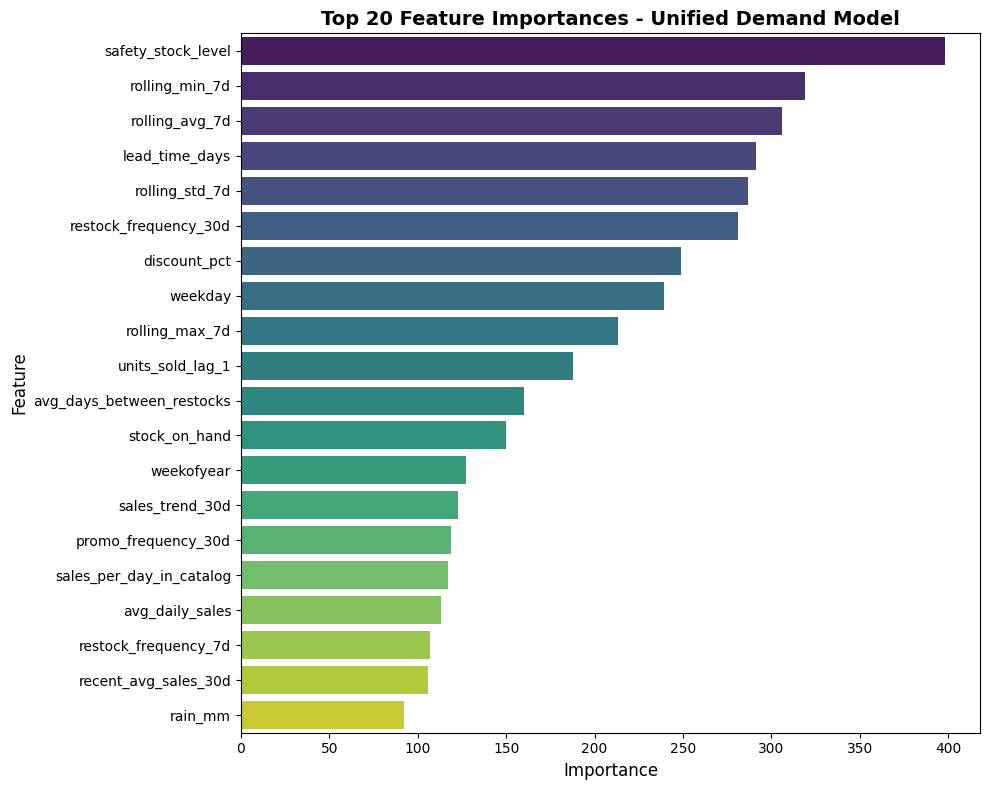


2️⃣ Comparing multiple model types:
MODEL COMPARISON
Approach: UNIFIED MODEL (Recommended)

Testing LIGHTGBM
TRAINING UNIFIED DEMAND MODEL
Model type: lightgbm
Training samples: 105570
  - With promotions: 8507 (8.1%)
  - Without promotions: 97063 (91.9%)
Validation samples: 3060
Test samples: 3060
Features: 82

📊 Discount distribution in training:
   (-0.001367, 0.0367]: 91.9%
   (0.0367, 0.0734]: 0.0%
   (0.0734, 0.11]: 2.0%
   (0.11, 0.147]: 0.5%
   (0.147, 0.183]: 1.5%

🚀 Training unified model...

----------------------------------------------------------------------
UNIFIED MODEL PERFORMANCE
----------------------------------------------------------------------

TRAIN (Overall):
  MAE:   41.56 units
  RMSE: 58.64 units
  R²:   0.9846
  MAPE:  7.73%

VAL (Overall):
  MAE:   47.80 units
  RMSE: 74.48 units
  R²:   0.9773
  MAPE:  8.36%

TEST (Overall):
  MAE:   48.22 units
  RMSE: 73.33 units
  R²:   0.9784
  MAPE:  8.12%

----------------------------------------------------------

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings. filterwarnings('ignore')

# ===================================
# SHARED MODEL TRAINING FUNCTION
# ===================================

def _train_model(X_train, y_train, X_val, y_val, model_type='lightgbm', tune_hyperparams=False):
    """
    Internal function to train a single model
    """
    # Handle any remaining NaN or inf values
    X_train = X_train.replace([np.inf, -np. inf], np.nan).fillna(0)
    X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Initialize model based on type
    if model_type == 'lightgbm': 
        if tune_hyperparams:
            params = {
                'objective': 'regression',
                'metric':  'mae',
                'num_leaves': 64,
                'learning_rate':  0.05,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': -1,
                'n_estimators': 500,
                'force_col_wise': True
            }
        else:
            params = {
                'objective':  'regression',
                'metric': 'mae',
                'num_leaves': 31,
                'learning_rate':  0.1,
                'verbose': -1,
                'n_estimators': 200,
                'force_col_wise': True
            }
        
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )
        
    elif model_type == 'xgboost':
        if tune_hyperparams:
            params = {
                'objective':  'reg:squarederror',
                'max_depth': 8,
                'learning_rate':  0.05,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'n_estimators': 500,
                'early_stopping_rounds': 50,
                'random_state': 42
            }
        else:
            params = {
                'objective': 'reg:squarederror',
                'max_depth': 6,
                'learning_rate':  0.1,
                'n_estimators': 200,
                'early_stopping_rounds':  50,
                'random_state': 42
            }
        
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
    elif model_type == 'random_forest':
        params = {
            'n_estimators': 200 if not tune_hyperparams else 500,
            'max_depth':  20 if not tune_hyperparams else 30,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'random_state': 42,
            'n_jobs': -1
        }
        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        
    elif model_type == 'gradient_boosting':
        params = {
            'n_estimators':  200 if not tune_hyperparams else 500,
            'learning_rate': 0.1 if not tune_hyperparams else 0.05,
            'max_depth': 5,
            'random_state': 42
        }
        model = GradientBoostingRegressor(**params)
        model.fit(X_train, y_train)
    
    else:
        raise ValueError(f"Unknown model_type: {model_type}.  Choose from: lightgbm, xgboost, random_forest, gradient_boosting")
    
    return model


def _calculate_metrics(y_true, y_pred):
    """
    Calculate regression metrics
    """
    # Ensure non-negative predictions
    y_pred = np.maximum(y_pred, 0)
    
    # MAPE:  Use original values without adding 1 (but avoid division by zero)
    mask = y_true > 0
    mape = np.mean(np. abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else 0
    
    return {
        'mae': mean_absolute_error(y_true, y_pred),
        'rmse': np. sqrt(mean_squared_error(y_true, y_pred)),
        'r2': r2_score(y_true, y_pred),
        'mape': mape
    }


# ===================================
# 🔥 NEW:  UNIFIED MODEL TRAINING
# ===================================

def train_unified_model(data, model_type='lightgbm', tune_hyperparams=False):
    """
    Train a SINGLE unified demand model (includes all data with promotion features)
    
    This replaces the separate baseline + promotion models approach. 
    
    Parameters:
    -----------
    data : dict
        Output from prepare_data_for_modeling()
    model_type : str
        'lightgbm', 'xgboost', 'random_forest', or 'gradient_boosting'
    tune_hyperparams : bool
        Whether to use tuned hyperparameters
    
    Returns:
    --------
    model : trained unified model
    metrics : dict of evaluation metrics
    predictions : dict of predictions for train/val/test
    """
    
    # Use promotion data (which includes all data:  promo + non-promo)
    if 'promotion' not in data:
        raise ValueError("Data dict must contain 'promotion' key")
    
    print("="*70)
    print("TRAINING UNIFIED DEMAND MODEL")
    print("="*70)
    print(f"Model type: {model_type}")
    print(f"Training samples: {len(data['promotion']['X_train'])}")
    
    # Show promotion distribution
    train_data = data['promotion']['train_data']
    n_promo = int(train_data['promo_flag'].sum())
    n_no_promo = int((train_data['promo_flag'] == 0).sum())
    
    print(f"  - With promotions: {n_promo} ({n_promo/len(train_data)*100:.1f}%)")
    print(f"  - Without promotions: {n_no_promo} ({n_no_promo/len(train_data)*100:.1f}%)")
    print(f"Validation samples: {len(data['promotion']['X_val'])}")
    print(f"Test samples: {len(data['promotion']['X_test'])}")
    print(f"Features: {len(data['promotion']['features'])}")
    
    # Show discount distribution
    discount_dist = train_data['discount_pct'].value_counts(bins=10, normalize=True).sort_index()
    print(f"\n📊 Discount distribution in training:")
    for bin_range, pct in discount_dist.head(5).items():
        print(f"   {bin_range}: {pct*100:.1f}%")
    
    # Get data
    X_train = data['promotion']['X_train']
    y_train = data['promotion']['y_train']
    X_val = data['promotion']['X_val']
    y_val = data['promotion']['y_val']
    X_test = data['promotion']['X_test']
    y_test = data['promotion']['y_test']
    
    # Train unified model
    print("\n🚀 Training unified model...")
    model = _train_model(X_train, y_train, X_val, y_val, model_type, tune_hyperparams)
    
    # Make predictions
    y_train_pred = model.predict(X_train. replace([np.inf, -np.inf], np.nan).fillna(0))
    y_val_pred = model.predict(X_val.replace([np. inf, -np.inf], np.nan).fillna(0))
    y_test_pred = model.predict(X_test. replace([np.inf, -np.inf], np.nan).fillna(0))
    
    # Calculate overall metrics
    metrics = {
        'train': _calculate_metrics(y_train, y_train_pred),
        'val': _calculate_metrics(y_val, y_val_pred),
        'test': _calculate_metrics(y_test, y_test_pred)
    }
    
    # Calculate metrics SEPARATELY for promo vs non-promo periods
    val_data = data['promotion']['val_data']
    test_data = data['promotion']['test_data']
    
    # Validation set breakdown
    val_promo_mask = val_data['promo_flag'] == 1
    val_no_promo_mask = val_data['promo_flag'] == 0
    
    if val_promo_mask.sum() > 0:
        metrics['val_promo'] = _calculate_metrics(
            y_val[val_promo_mask], 
            y_val_pred[val_promo_mask]
        )
    
    if val_no_promo_mask.sum() > 0:
        metrics['val_no_promo'] = _calculate_metrics(
            y_val[val_no_promo_mask], 
            y_val_pred[val_no_promo_mask]
        )
    
    # Test set breakdown
    test_promo_mask = test_data['promo_flag'] == 1
    test_no_promo_mask = test_data['promo_flag'] == 0
    
    if test_promo_mask.sum() > 0:
        metrics['test_promo'] = _calculate_metrics(
            y_test[test_promo_mask], 
            y_test_pred[test_promo_mask]
        )
    
    if test_no_promo_mask.sum() > 0:
        metrics['test_no_promo'] = _calculate_metrics(
            y_test[test_no_promo_mask], 
            y_test_pred[test_no_promo_mask]
        )
    
    # Store predictions
    predictions = {
        'train': y_train_pred,
        'val': y_val_pred,
        'test': y_test_pred
    }
    
    # Print results
    print("\n" + "-"*70)
    print("UNIFIED MODEL PERFORMANCE")
    print("-"*70)
    
    for split in ['train', 'val', 'test']:
        print(f"\n{split.upper()} (Overall):")
        print(f"  MAE:   {metrics[split]['mae']:.2f} units")
        print(f"  RMSE: {metrics[split]['rmse']:.2f} units")
        print(f"  R²:   {metrics[split]['r2']:.4f}")
        print(f"  MAPE:  {metrics[split]['mape']:.2f}%")
    
    # Show breakdown
    if 'val_promo' in metrics and 'val_no_promo' in metrics:
        print(f"\n{'-'*70}")
        print("VALIDATION SET BREAKDOWN:")
        print(f"{'-'*70}")
        print(f"  WITH Promotions    (n={val_promo_mask.sum()}):")
        print(f"    MAE:  {metrics['val_promo']['mae']:.2f} units")
        print(f"    R²:   {metrics['val_promo']['r2']:.4f}")
        print(f"  WITHOUT Promotions (n={val_no_promo_mask. sum()}):")
        print(f"    MAE:  {metrics['val_no_promo']['mae']:.2f} units")
        print(f"    R²:   {metrics['val_no_promo']['r2']:.4f}")
    
    if 'test_promo' in metrics and 'test_no_promo' in metrics:
        print(f"\nTEST SET BREAKDOWN:")
        print(f"{'-'*70}")
        print(f"  WITH Promotions    (n={test_promo_mask.sum()}):")
        print(f"    MAE:  {metrics['test_promo']['mae']:.2f} units")
        print(f"    R²:    {metrics['test_promo']['r2']:.4f}")
        print(f"  WITHOUT Promotions (n={test_no_promo_mask.sum()}):")
        print(f"    MAE:  {metrics['test_no_promo']['mae']:.2f} units")
        print(f"    R²:   {metrics['test_no_promo']['r2']:.4f}")
    
    return model, metrics, predictions


# ===================================
# 🔥 BACKWARD COMPATIBLE:  Keep old functions for comparison
# ===================================

def train_baseline_model(data, model_type='lightgbm', tune_hyperparams=False):
    """
    Train baseline demand model (no promotions)
    ⚠️ DEPRECATED: Use train_unified_model() instead for smooth discount curves
    """
    
    if 'baseline' not in data:
        raise ValueError("Data dict must contain 'baseline' key")
    
    print("="*70)
    print("TRAINING BASELINE DEMAND MODEL")
    print("="*70)
    print("⚠️  NOTE: Using separate baseline model (old approach)")
    print("⚠️  Consider using train_unified_model() for better discount sensitivity")
    print(f"Model type: {model_type}")
    print(f"Training samples:  {len(data['baseline']['X_train'])}")
    print(f"Validation samples: {len(data['baseline']['X_val'])}")
    print(f"Test samples: {len(data['baseline']['X_test'])}")
    print(f"Features: {len(data['baseline']['features'])}")
    
    # Get data
    X_train = data['baseline']['X_train']
    y_train = data['baseline']['y_train']
    X_val = data['baseline']['X_val']
    y_val = data['baseline']['y_val']
    X_test = data['baseline']['X_test']
    y_test = data['baseline']['y_test']
    
    # Train model
    model = _train_model(X_train, y_train, X_val, y_val, model_type, tune_hyperparams)
    
    # Make predictions
    y_train_pred = model.predict(X_train.replace([np.inf, -np. inf], np.nan).fillna(0))
    y_val_pred = model.predict(X_val.replace([np.inf, -np.inf], np. nan).fillna(0))
    y_test_pred = model.predict(X_test.replace([np.inf, -np. inf], np.nan).fillna(0))
    
    # Calculate metrics
    metrics = {
        'train': _calculate_metrics(y_train, y_train_pred),
        'val': _calculate_metrics(y_val, y_val_pred),
        'test': _calculate_metrics(y_test, y_test_pred)
    }
    
    predictions = {
        'train': y_train_pred,
        'val': y_val_pred,
        'test': y_test_pred
    }
    
    # Print results
    print("\n" + "-"*70)
    print("BASELINE MODEL PERFORMANCE")
    print("-"*70)
    for split in ['train', 'val', 'test']:
        print(f"\n{split.upper()}:")
        print(f"  MAE:  {metrics[split]['mae']:.2f} units")
        print(f"  RMSE: {metrics[split]['rmse']:.2f} units")
        print(f"  R²:   {metrics[split]['r2']:.4f}")
        print(f"  MAPE: {metrics[split]['mape']:.2f}%")
    
    return model, metrics, predictions


def train_promotion_model(data, model_type='lightgbm', tune_hyperparams=False):
    """
    Train promotion demand model (with promotion features)
    ⚠️ DEPRECATED:  Use train_unified_model() instead for smooth discount curves
    """
    
    if 'promotion' not in data:
        raise ValueError("Data dict must contain 'promotion' key")
    
    print("\n" + "="*70)
    print("TRAINING PROMOTION DEMAND MODEL")
    print("="*70)
    print("⚠️  NOTE: Using separate promotion model (old approach)")
    print("⚠️  Consider using train_unified_model() for better discount sensitivity")
    print(f"Model type: {model_type}")
    print(f"Training samples:  {len(data['promotion']['X_train'])}")
    
    train_data = data['promotion']['train_data']
    n_promo = int(train_data['promo_flag'].sum())
    n_no_promo = int((train_data['promo_flag'] == 0).sum())
    
    print(f"  - With promotions: {n_promo}")
    print(f"  - Without promotions: {n_no_promo}")
    print(f"Validation samples: {len(data['promotion']['X_val'])}")
    print(f"Test samples: {len(data['promotion']['X_test'])}")
    print(f"Features: {len(data['promotion']['features'])}")
    
    # Get data
    X_train = data['promotion']['X_train']
    y_train = data['promotion']['y_train']
    X_val = data['promotion']['X_val']
    y_val = data['promotion']['y_val']
    X_test = data['promotion']['X_test']
    y_test = data['promotion']['y_test']
    
    # Train model
    model = _train_model(X_train, y_train, X_val, y_val, model_type, tune_hyperparams)
    
    # Make predictions
    y_train_pred = model.predict(X_train.replace([np.inf, -np.inf], np.nan).fillna(0))
    y_val_pred = model.predict(X_val.replace([np.inf, -np.inf], np.nan).fillna(0))
    y_test_pred = model.predict(X_test.replace([np.inf, -np.inf], np.nan).fillna(0))
    
    # Calculate metrics
    metrics = {
        'train': _calculate_metrics(y_train, y_train_pred),
        'val': _calculate_metrics(y_val, y_val_pred),
        'test': _calculate_metrics(y_test, y_test_pred)
    }
    
    predictions = {
        'train':  y_train_pred,
        'val': y_val_pred,
        'test': y_test_pred
    }
    
    # Print results
    print("\n" + "-"*70)
    print("PROMOTION MODEL PERFORMANCE")
    print("-"*70)
    for split in ['train', 'val', 'test']:
        print(f"\n{split.upper()}:")
        print(f"  MAE:  {metrics[split]['mae']:.2f} units")
        print(f"  RMSE: {metrics[split]['rmse']:.2f} units")
        print(f"  R²:   {metrics[split]['r2']:.4f}")
        print(f"  MAPE: {metrics[split]['mape']:.2f}%")
    
    return model, metrics, predictions


# ===================================
# UTILITY FUNCTIONS
# ===================================

def plot_feature_importance(model, features, model_name='Model', top_n=20, save_path=None):
    """
    Plot feature importance
    """
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
    else:
        print("⚠️ Model doesn't support feature importance")
        return None
    
    if len(features) != len(importance):
        print(f"⚠️ Warning: Feature count mismatch ({len(features)} vs {len(importance)})")
        return None
    
    feat_imp = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feat_imp. head(top_n), x='importance', y='feature', palette='viridis')
    plt.title(f'Top {top_n} Feature Importances - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to:  {save_path}")
    
    plt.show()
    
    return feat_imp


def compare_models(data, models_to_try=['lightgbm', 'xgboost', 'random_forest'], use_unified=True):
    """
    Train and compare multiple model types
    
    Parameters:
    -----------
    data : dict from prepare_data_for_modeling()
    models_to_try : list of model type strings
    use_unified : bool, if True uses unified model (recommended)
    
    Returns:
    --------
    results : dict of all models and metrics
    best_model : str, name of best model
    """
    results = {}
    
    print("="*70)
    print("MODEL COMPARISON")
    print("="*70)
    print(f"Approach: {'UNIFIED MODEL (Recommended)' if use_unified else 'Separate Baseline + Promo Models (Old)'}")
    
    for model_type in models_to_try:
        print(f"\n{'='*70}")
        print(f"Testing {model_type.upper()}")
        print(f"{'='*70}")
        
        try:
            if use_unified:
                # Train unified model
                model, metrics, preds = train_unified_model(data, model_type=model_type)
                results[model_type] = {
                    'model': model,
                    'metrics': metrics,
                    'predictions': preds
                }
            else:
                # Train separate models (old approach)
                baseline_model, baseline_metrics, baseline_preds = train_baseline_model(
                    data, model_type=model_type
                )
                promo_model, promo_metrics, promo_preds = train_promotion_model(
                    data, model_type=model_type
                )
                results[model_type] = {
                    'baseline_model': baseline_model,
                    'promo_model': promo_model,
                    'baseline_metrics': baseline_metrics,
                    'promo_metrics': promo_metrics
                }
            
        except Exception as e:
            print(f"❌ Error training {model_type}: {str(e)}")
            continue
    
    # Summary comparison
    print("\n" + "="*70)
    print("MODEL COMPARISON SUMMARY")
    print("="*70)
    
    if use_unified:
        print(f"\n{'Model':<20} {'Val MAE': >10} {'Val RMSE':>10} {'Val R²':>8} {'Val MAPE':>8}")
        print("-"*60)
        for model_type in models_to_try:
            if model_type in results:
                m = results[model_type]['metrics']['val']
                print(f"{model_type:<20} {m['mae']:>10.2f} {m['rmse']:>10.2f} {m['r2']:>8.4f} {m['mape']:>7.2f}%")
        
        # Find best
        valid_models = [m for m in models_to_try if m in results]
        if valid_models:
            best_model = min(valid_models, key=lambda x: results[x]['metrics']['val']['mae'])
            print(f"\n✓ Best model: {best_model} (MAE: {results[best_model]['metrics']['val']['mae']:.2f})")
            return results, best_model
    else:
        print(f"\nBASELINE MODELS:")
        print(f"{'Model':<20} {'Val MAE':>10} {'Val R²':>8}")
        print("-"*40)
        for model_type in models_to_try:
            if model_type in results and 'baseline_metrics' in results[model_type]:
                m = results[model_type]['baseline_metrics']['val']
                print(f"{model_type:<20} {m['mae']:>10.2f} {m['r2']:>8.4f}")
        
        print(f"\nPROMOTION MODELS:")
        print(f"{'Model':<20} {'Val MAE':>10} {'Val R²':>8}")
        print("-"*40)
        for model_type in models_to_try:
            if model_type in results and 'promo_metrics' in results[model_type]: 
                m = results[model_type]['promo_metrics']['val']
                print(f"{model_type:<20} {m['mae']:>10.2f} {m['r2']:>8.4f}")
    
    return results, None


# ===================================
# USAGE EXAMPLE
# ===================================
if __name__ == "__main__": 
    
    print("\n" + "="*70)
    print("EXAMPLE USAGE")
    print("="*70)
    
    # 🔥 NEW RECOMMENDED APPROACH: Unified Model
    print("\n1️⃣ Training UNIFIED model (Recommended):")
    unified_model, unified_metrics, unified_preds = train_unified_model(data, model_type='lightgbm')
    
    # Plot feature importance
    feat_imp = plot_feature_importance(
        unified_model,
        data['promotion']['features'],
        model_name='Unified Demand Model'
    )
    
    # Compare multiple models
    print("\n2️⃣ Comparing multiple model types:")
    results, best_model = compare_models(
        data,
        models_to_try=['lightgbm', 'xgboost', 'random_forest'],
        use_unified=True
    )
    
    print("\n" + "="*70)
    print("✅ Training complete!  Use 'unified_model' for predictions.")
    print("="*70)


MODEL ANALYSIS & OPTIMIZATION (UNIFIED MODEL)

1. Visualizing Forecast Accuracy...

VISUAL FORECAST INSPECTION - Unified Model
Test Set Performance:
  MAE:   48.22 units
  MAPE:  8.10%
  Total Actual:      1,973,673 units
  Total Predicted:   1,965,355 units


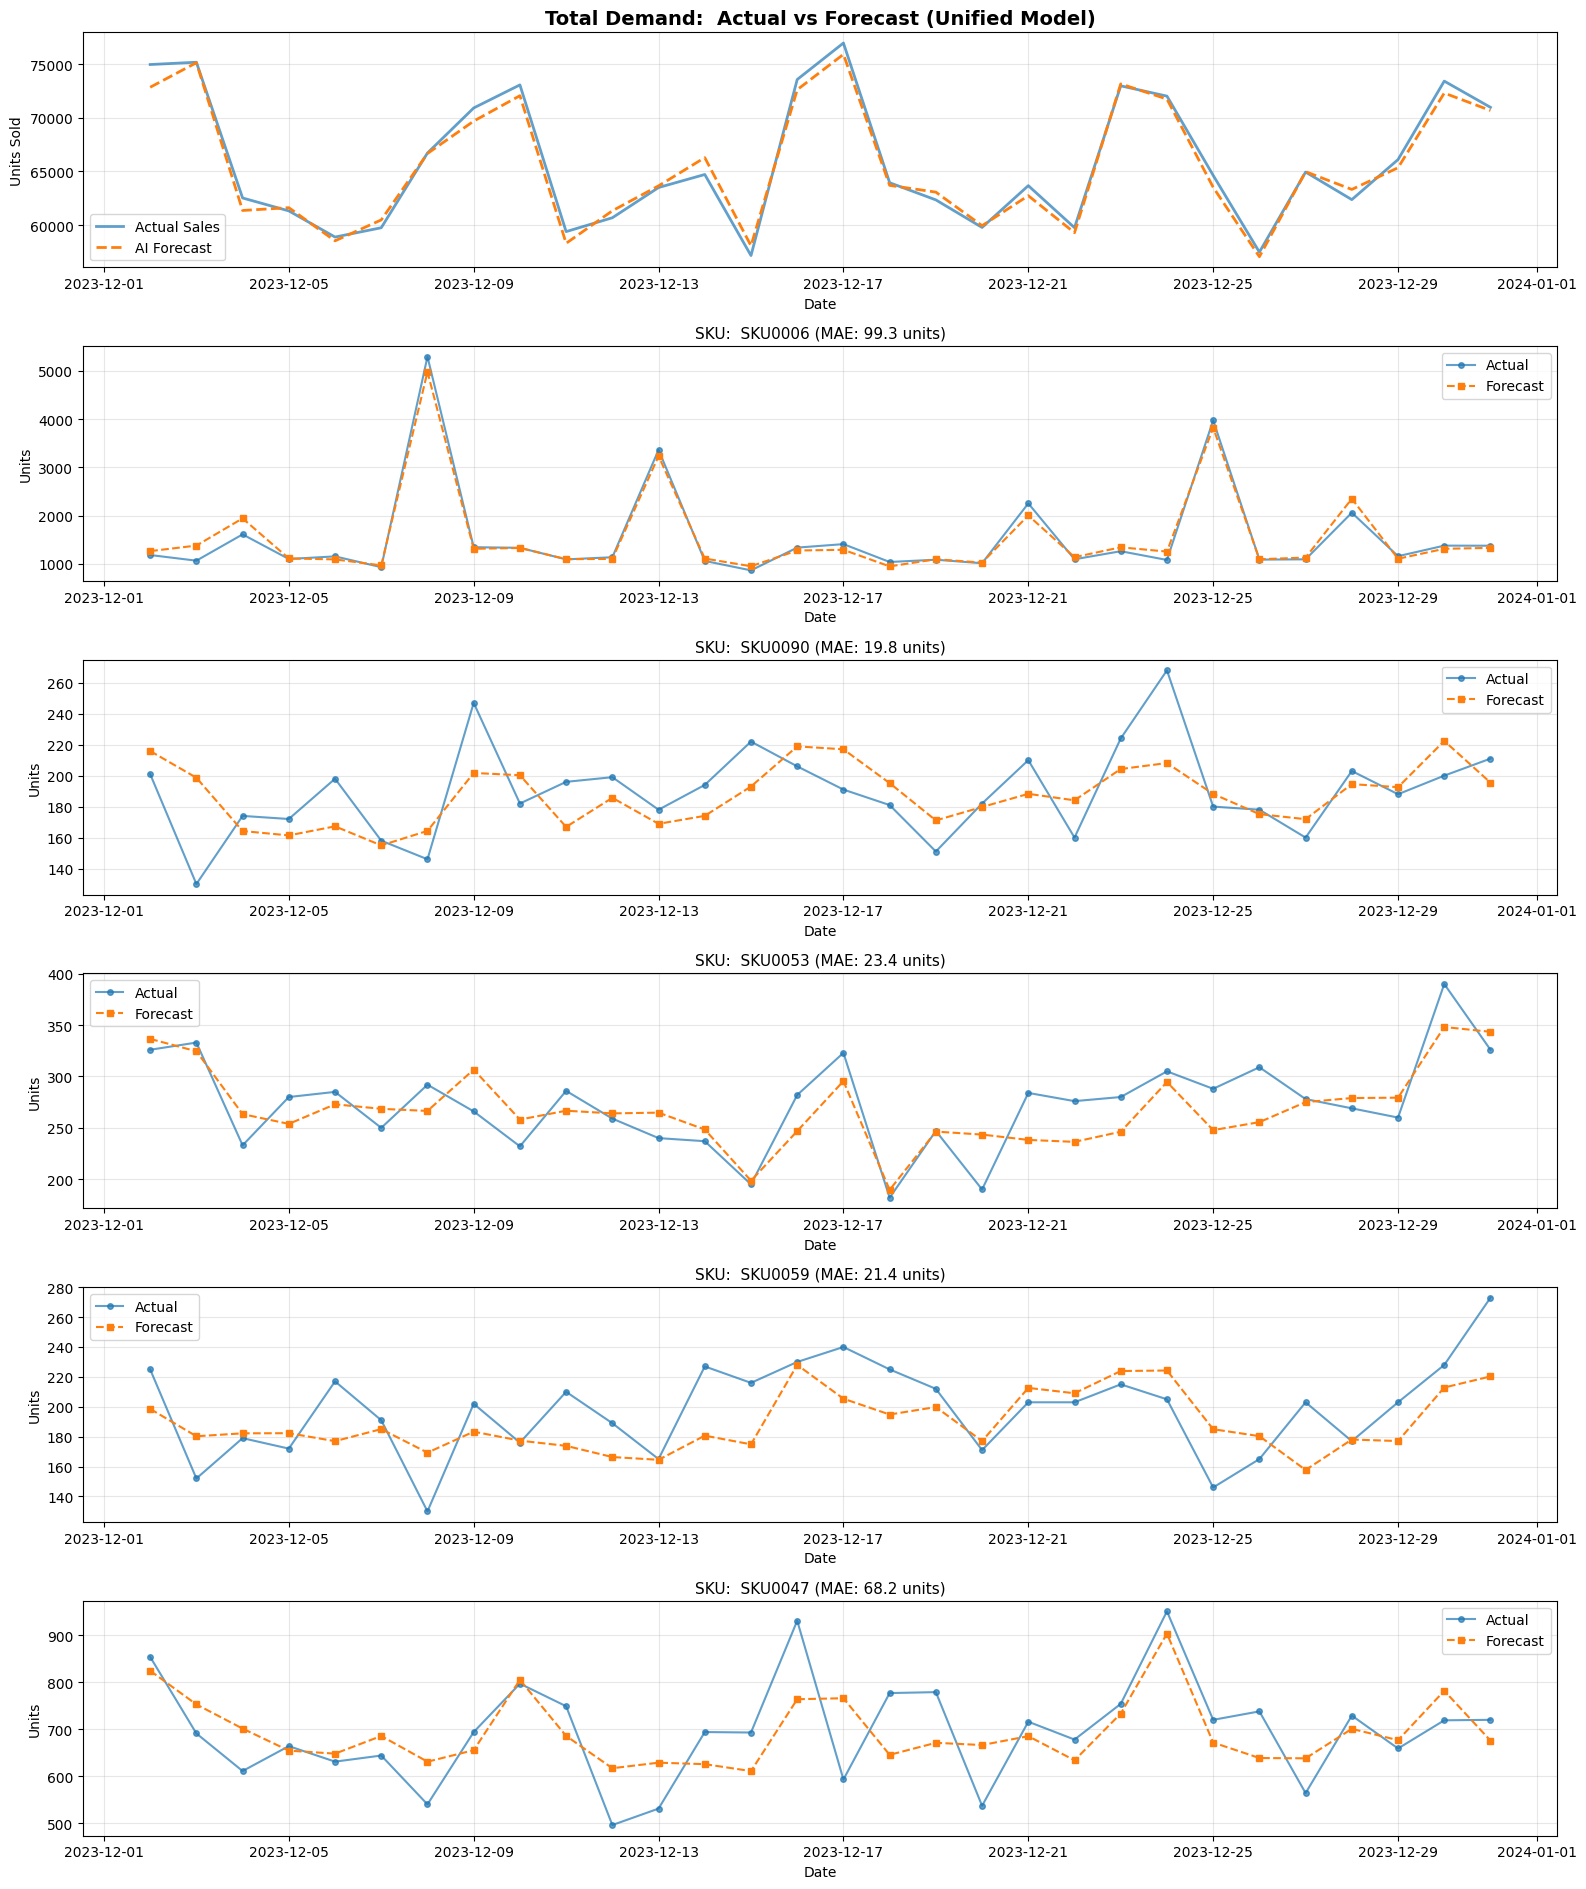


2. Analyzing Feature Importance...


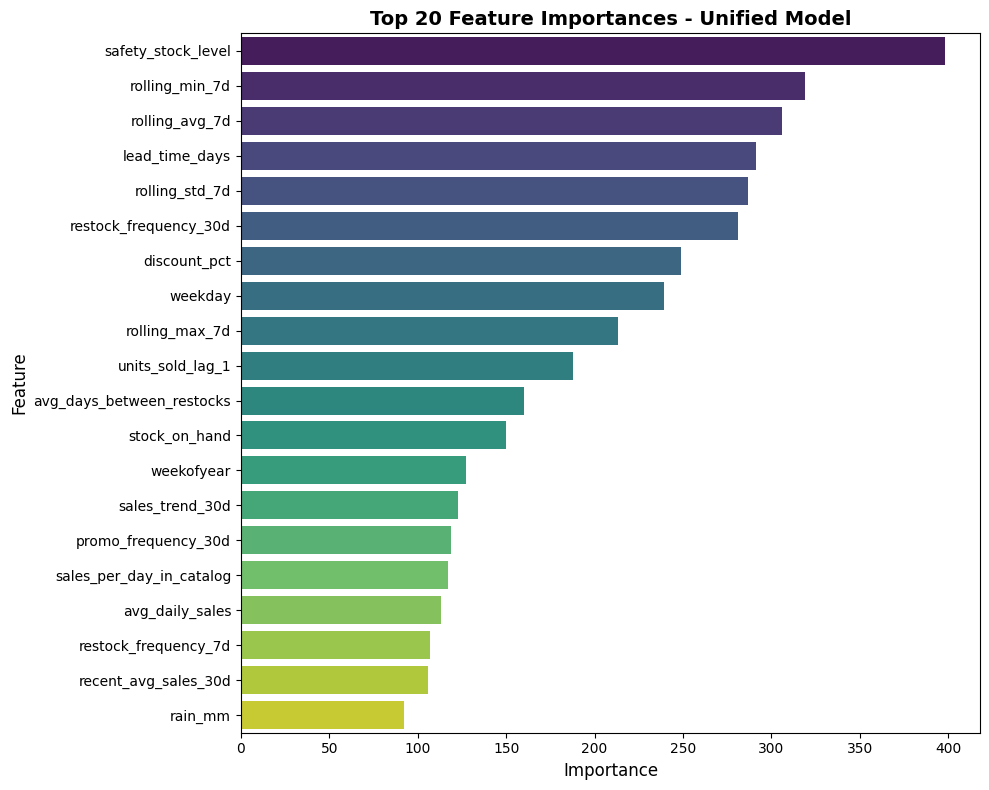


3. Running Price Optimization with Unified Model...

PRICE OPTIMIZATION FOR SKU: SKU0001
  Current Price: $6.24
  Unit Cost:      $3.99
  Base Margin:   $2.25 (36.0%)
  Baseline Demand (no promo): 1357.5 units

🔥 Using UNIFIED MODEL for smooth 0%-50% predictions
Simulating 11 discount scenarios.. .

----------------------------------------------------------------------
OPTIMIZATION RESULTS
----------------------------------------------------------------------

Discount   Price      Units      Lift         Profit      
----------------------------------------------------------------------
0%         $6.24      1357        0.0%        $3,053      
5%         $5.93      1758        29.5%       $3,406      
10%        $5.62      1949        43.6%       $3,167      
15%        $5.30      1957        44.1%       $2,570      
20%        $4.99      2038        50.1%       $2,041      
25%        $4.68      2221        63.6%       $1,531      
30%        $4.37      2286        68.4%       $862

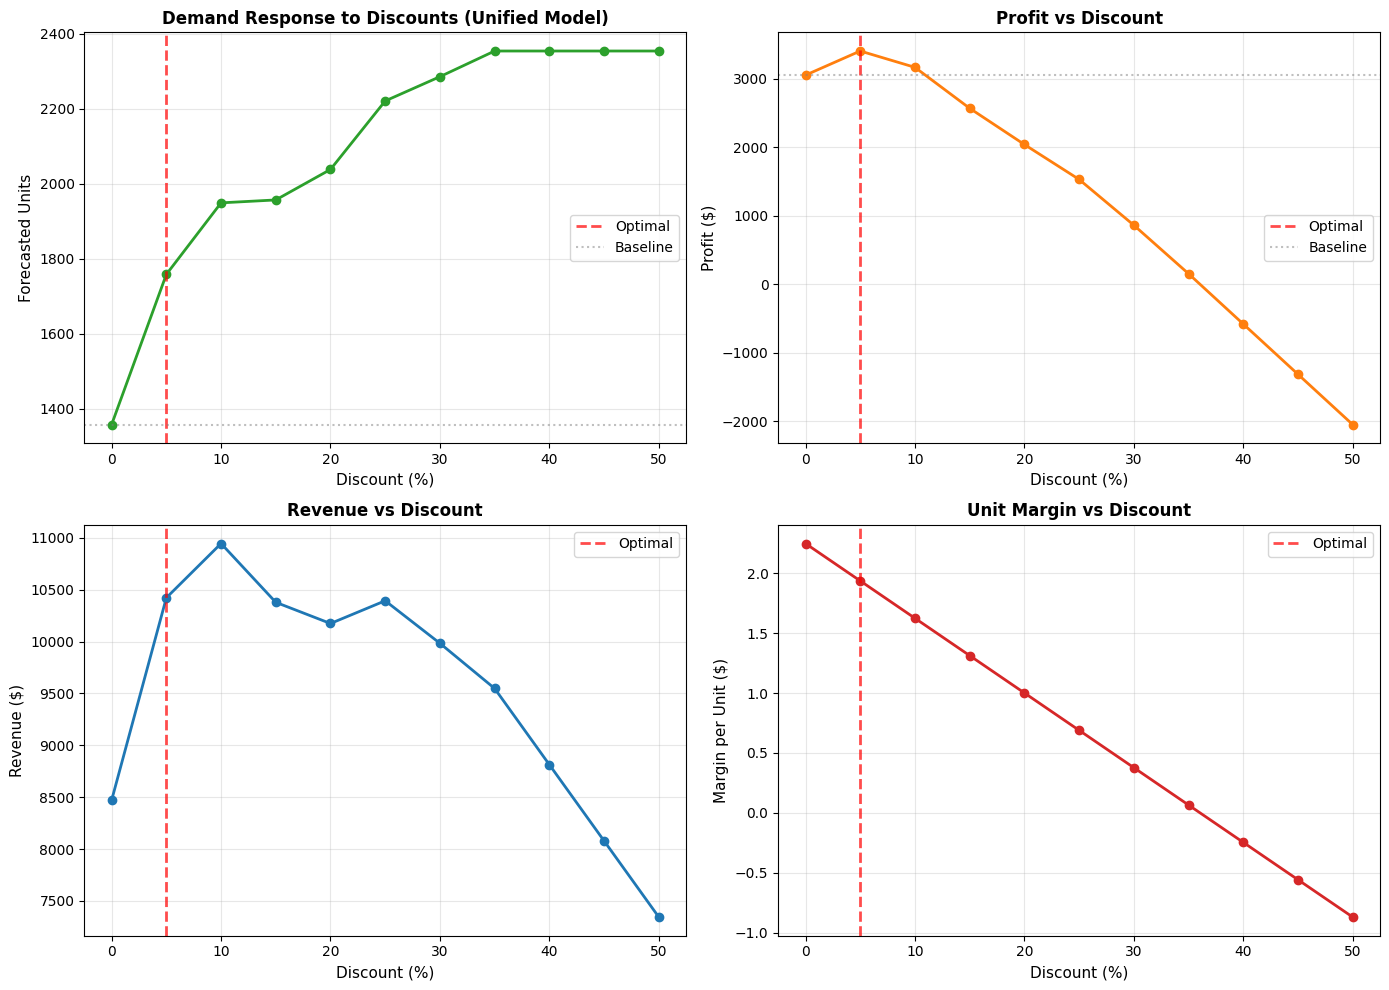

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ==========================================
# STEP 6: MODEL ANALYSIS & OPTIMIZATION (UNIFIED MODEL)
# ==========================================

def plot_forecast_vs_actual(model, X_test, y_test, test_data, model_name='Model', n_samples=5):
    """
    Visually compare Actual Sales vs Model Predictions
    
    Parameters:
    -----------
    model :   trained unified model
    X_test : DataFrame of test features
    y_test : Series of test targets
    test_data : DataFrame containing original test data with 'date' column
    model_name : str, name for plot title
    n_samples : int, number of sample SKUs to plot individually
    """
    print("\n" + "="*70)
    print(f"VISUAL FORECAST INSPECTION - {model_name}")
    print("="*70)
    
    # Make predictions
    X_test_clean = X_test.replace([np.inf, -np. inf], np.nan).fillna(0)
    preds = model.predict(X_test_clean)
    preds = np.maximum(preds, 0)  # Ensure non-negative
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Date': test_data['date']. values,
        'sku_id': test_data['sku_id'].values,
        'Actual': y_test.values,
        'Predicted': preds,
        'Error': y_test.values - preds,
        'Error_Pct': ((y_test.values - preds) / (y_test.values + 1)) * 100
    })
    
    # Calculate overall metrics
    mae = np.mean(np.abs(results_df['Error']))
    mape = np.mean(np.abs(results_df['Error_Pct']))
    
    print(f"Test Set Performance:")
    print(f"  MAE:   {mae:.2f} units")
    print(f"  MAPE:  {mape:.2f}%")
    print(f"  Total Actual:      {results_df['Actual'].sum():,.0f} units")
    print(f"  Total Predicted:   {results_df['Predicted']. sum():,.0f} units")
    
    # Plot 1: Total Aggregated Demand (All SKUs Combined)
    fig = plt.figure(figsize=(16, 4 + 3*n_samples))
    
    plt.subplot(n_samples + 1, 1, 1)
    daily_totals = results_df.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()
    plt.plot(daily_totals['Date'], daily_totals['Actual'], 
             label='Actual Sales', color='#1f77b4', alpha=0.7, linewidth=2)
    plt.plot(daily_totals['Date'], daily_totals['Predicted'], 
             label='AI Forecast', color='#ff7f0e', linewidth=2, linestyle='--')
    plt.title(f"Total Demand:  Actual vs Forecast ({model_name})", fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2-N: Individual SKU Samples
    unique_skus = results_df['sku_id'].unique()
    if len(unique_skus) > n_samples:
        sample_skus = np.random.choice(unique_skus, n_samples, replace=False)
    else:
        sample_skus = unique_skus[:n_samples]
    
    for idx, sku in enumerate(sample_skus, start=2):
        plt.subplot(n_samples + 1, 1, idx)
        sku_data = results_df[results_df['sku_id'] == sku]. sort_values('Date')
        
        plt.plot(sku_data['Date'], sku_data['Actual'], 
                label='Actual', color='#1f77b4', marker='o', markersize=4, alpha=0.7)
        plt.plot(sku_data['Date'], sku_data['Predicted'], 
                label='Forecast', color='#ff7f0e', marker='s', markersize=4, linestyle='--')
        
        sku_mae = np.mean(np.abs(sku_data['Error']))
        plt.title(f"SKU:  {sku} (MAE: {sku_mae:.1f} units)", fontsize=11)
        plt.xlabel('Date')
        plt.ylabel('Units')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df


def optimize_price_unified(unified_model, features, sample_row, current_price, cost, 
                           sku_id='Unknown', elasticity_fallback=-2.0):
    """
    🔥 NEW:  Simulate different discount levels using UNIFIED MODEL
    
    Parameters:
    -----------
    unified_model : trained unified model
    features : list of feature names
    sample_row : Series or dict of feature values for a specific SKU/date
    current_price : float, current list price
    cost :  float, unit cost
    sku_id : str, SKU identifier for display
    elasticity_fallback :  float, fallback price elasticity (not usually needed)
    
    Returns:
    --------
    DataFrame with optimization results
    """
    
    print("\n" + "="*70)
    print(f"PRICE OPTIMIZATION FOR SKU: {sku_id}")
    print("="*70)
    print(f"  Current Price: ${current_price:.2f}")
    print(f"  Unit Cost:      ${cost:.2f}")
    print(f"  Base Margin:   ${current_price - cost:.2f} ({((current_price-cost)/current_price)*100:.1f}%)")
    
    # Test discount range:  0% to 50% in 5% increments
    discounts = np.arange(0, 0.55, 0.05)
    results = []
    
    # Prepare base row
    base_row = pd.DataFrame([sample_row])[features].copy()
    base_row = base_row.replace([np. inf, -np.inf], np.nan).fillna(0)
    
    # Get baseline demand (0% discount)
    baseline_row = base_row.copy()
    if 'discount_pct' in baseline_row.columns:
        baseline_row['discount_pct'] = 0.0
    if 'promo_flag' in baseline_row.columns:
        baseline_row['promo_flag'] = 0
    if 'discount_amount' in baseline_row.columns:
        baseline_row['discount_amount'] = 0.0
    if 'avg_discount_when_promo_30d' in baseline_row.columns:
        baseline_row['avg_discount_when_promo_30d'] = 0.0
    
    # Update polynomial features for 0% discount
    if 'discount_pct_squared' in baseline_row.columns:
        baseline_row['discount_pct_squared'] = 0.0
    if 'discount_pct_cubed' in baseline_row.columns:
        baseline_row['discount_pct_cubed'] = 0.0
    if 'discount_pct_sqrt' in baseline_row.columns:
        baseline_row['discount_pct_sqrt'] = 0.0
    if 'discount_pct_log' in baseline_row.columns:
        baseline_row['discount_pct_log'] = 0.0
    if 'discount_price_interaction' in baseline_row.columns:
        baseline_row['discount_price_interaction'] = 0.0
    if 'discount_margin_interaction' in baseline_row. columns:
        baseline_row['discount_margin_interaction'] = 0.0
    
    base_demand = unified_model.predict(baseline_row)[0]
    base_demand = max(base_demand, 0)
    
    print(f"  Baseline Demand (no promo): {base_demand:.1f} units")
    print(f"\n🔥 Using UNIFIED MODEL for smooth 0%-50% predictions")
    print(f"Simulating {len(discounts)} discount scenarios.. .\n")
    
    for discount in discounts:
        discounted_price = current_price * (1 - discount)
        margin = discounted_price - cost
        
        try:
            # Create scenario row
            scenario_row = base_row.copy()
            
            # Update discount-related features
            if 'discount_pct' in scenario_row.columns:
                scenario_row['discount_pct'] = discount
            if 'promo_flag' in scenario_row.columns:
                scenario_row['promo_flag'] = 1 if discount > 0 else 0
            if 'discount_amount' in scenario_row.columns:
                scenario_row['discount_amount'] = current_price * discount
            if 'avg_discount_when_promo_30d' in scenario_row.columns:
                scenario_row['avg_discount_when_promo_30d'] = discount if discount > 0 else 0
            
            # 🔥 Update polynomial features
            if 'discount_pct_squared' in scenario_row. columns:
                scenario_row['discount_pct_squared'] = discount ** 2
            if 'discount_pct_cubed' in scenario_row.columns:
                scenario_row['discount_pct_cubed'] = discount ** 3
            if 'discount_pct_sqrt' in scenario_row.columns:
                scenario_row['discount_pct_sqrt'] = np.sqrt(discount)
            if 'discount_pct_log' in scenario_row.columns:
                scenario_row['discount_pct_log'] = np. log1p(discount)
            if 'discount_price_interaction' in scenario_row.columns:
                scenario_row['discount_price_interaction'] = discount * current_price
            if 'discount_margin_interaction' in scenario_row.columns:
                base_margin = scenario_row['discount_margin_interaction']. values[0] / sample_row. get('discount_pct', 1) if sample_row.get('discount_pct', 0) > 0 else 0
                scenario_row['discount_margin_interaction'] = discount * base_margin
            
            # Predict with unified model
            pred_units = unified_model.predict(scenario_row)[0]
            pred_units = max(pred_units, 0)
            model_used = "Unified AI"
            lift_pct = ((pred_units - base_demand) / base_demand) * 100 if base_demand > 0 else 0
            
        except Exception as e:
            # Fallback to elasticity rule (should rarely happen)
            lift = abs(elasticity_fallback) * discount
            pred_units = base_demand * (1 + lift)
            model_used = "Elasticity Fallback"
            lift_pct = lift * 100
            print(f"  ⚠️ Using fallback for {discount*100:.0f}% discount:  {str(e)[:50]}")
        
        # Calculate financial metrics
        revenue = pred_units * discounted_price
        profit = pred_units * margin
        baseline_profit = base_demand * (current_price - cost)
        roi = ((profit - baseline_profit) / baseline_profit * 100) if baseline_profit > 0 else 0
        
        results.append({
            'Discount': f"{discount*100:.0f}%",
            'Discount_Val': discount,
            'Price': discounted_price,
            'Margin': margin,
            'Forecast_Units': pred_units,
            'Lift_vs_Base': f"{lift_pct: .1f}%",
            'Revenue': revenue,
            'Profit': profit,
            'ROI_vs_Base': f"{roi:.1f}%",
            'Model': model_used
        })
    
    results_df = pd.DataFrame(results)
    
    # Find optimal discount
    optimal_idx = results_df['Profit'].idxmax()
    optimal = results_df.loc[optimal_idx]
    
    print("-"*70)
    print("OPTIMIZATION RESULTS")
    print("-"*70)
    print(f"\n{'Discount':<10} {'Price':<10} {'Units':<10} {'Lift':<12} {'Profit':<12}")
    print("-"*70)
    for _, row in results_df.iterrows():
        print(f"{row['Discount']:<10} ${row['Price']:<9.2f} {row['Forecast_Units']:<10.0f} "
              f"{row['Lift_vs_Base']:<12} ${row['Profit']:<11,.0f}")
    
    print("\n" + "="*70)
    print("🎯 OPTIMAL PRICING STRATEGY")
    print("="*70)
    print(f"  Best Discount:     {optimal['Discount']}")
    print(f"  Optimal Price:     ${optimal['Price']:.2f}")
    print(f"  Expected Demand:   {optimal['Forecast_Units']:.0f} units ({optimal['Lift_vs_Base']})")
    print(f"  Expected Revenue:   ${optimal['Revenue']: ,.2f}")
    print(f"  Expected Profit:   ${optimal['Profit']:,.2f}")
    print(f"  ROI vs No Promo:   {optimal['ROI_vs_Base']}")
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Demand vs Discount
    axes[0, 0].plot(results_df['Discount_Val']*100, results_df['Forecast_Units'], 
                    marker='o', linewidth=2, color='#2ca02c', markersize=6)
    axes[0, 0].axvline(optimal['Discount_Val']*100, color='red', linestyle='--', 
                       alpha=0.7, linewidth=2, label='Optimal')
    axes[0, 0].axhline(base_demand, color='gray', linestyle=':', alpha=0.5, label='Baseline')
    axes[0, 0].set_xlabel('Discount (%)', fontsize=11)
    axes[0, 0].set_ylabel('Forecasted Units', fontsize=11)
    axes[0, 0].set_title('Demand Response to Discounts (Unified Model)', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # Plot 2: Profit vs Discount
    axes[0, 1].plot(results_df['Discount_Val']*100, results_df['Profit'], 
                    marker='o', linewidth=2, color='#ff7f0e', markersize=6)
    axes[0, 1].axvline(optimal['Discount_Val']*100, color='red', linestyle='--', 
                       alpha=0.7, linewidth=2, label='Optimal')
    axes[0, 1]. axhline(base_demand * (current_price - cost), color='gray', 
                       linestyle=':', alpha=0.5, label='Baseline')
    axes[0, 1].set_xlabel('Discount (%)', fontsize=11)
    axes[0, 1].set_ylabel('Profit ($)', fontsize=11)
    axes[0, 1].set_title('Profit vs Discount', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # Plot 3: Revenue vs Discount
    axes[1, 0].plot(results_df['Discount_Val']*100, results_df['Revenue'], 
                    marker='o', linewidth=2, color='#1f77b4', markersize=6)
    axes[1, 0].axvline(optimal['Discount_Val']*100, color='red', linestyle='--', 
                       alpha=0.7, linewidth=2, label='Optimal')
    axes[1, 0].set_xlabel('Discount (%)', fontsize=11)
    axes[1, 0].set_ylabel('Revenue ($)', fontsize=11)
    axes[1, 0].set_title('Revenue vs Discount', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # Plot 4: Margin vs Discount
    axes[1, 1].plot(results_df['Discount_Val']*100, results_df['Margin'], 
                    marker='o', linewidth=2, color='#d62728', markersize=6)
    axes[1, 1].axvline(optimal['Discount_Val']*100, color='red', linestyle='--', 
                       alpha=0.7, linewidth=2, label='Optimal')
    axes[1, 1].set_xlabel('Discount (%)', fontsize=11)
    axes[1, 1].set_ylabel('Margin per Unit ($)', fontsize=11)
    axes[1, 1].set_title('Unit Margin vs Discount', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return results_df


# ==========================================
# USAGE EXAMPLE
# ==========================================
if __name__ == "__main__": 
    
    print("\n" + "="*70)
    print("MODEL ANALYSIS & OPTIMIZATION (UNIFIED MODEL)")
    print("="*70)
    
    # 1. Visual Forecast Check
    print("\n1. Visualizing Forecast Accuracy...")
    forecast_results = plot_forecast_vs_actual(
        unified_model, 
        data['promotion']['X_test'], 
        data['promotion']['y_test'],
        data['promotion']['test_data'],
        model_name='Unified Model'
    )
    
    # 2. Feature Importance
    print("\n2. Analyzing Feature Importance...")
    feat_imp = plot_feature_importance(
        unified_model, 
        data['promotion']['features'], 
        model_name='Unified Model',
        top_n=20
    )
    
    # 3. Price Optimization Example (🔥 NEW:  Using Unified Model)
    print("\n3. Running Price Optimization with Unified Model...")
    
    # Select a sample row from test set (most recent date for a specific SKU)
    test_data = data['promotion']['test_data']
    sample_sku = test_data['sku_id']. iloc[0]
    sample_date = test_data['date'].max()
    
    sample_mask = (test_data['sku_id'] == sample_sku) & (test_data['date'] == sample_date)
    sample_row = test_data[sample_mask]. iloc[0]
    
    # Get price and cost
    current_price = sample_row['list_price']
    cost = sample_row['purchase_cost'] if 'purchase_cost' in sample_row else current_price * 0.6
    
    # 🔥 Run optimization with UNIFIED MODEL
    optimization_results = optimize_price_unified(
        unified_model=unified_model,
        features=data['promotion']['features'],
        sample_row=sample_row,
        current_price=current_price,
        cost=cost,
        sku_id=sample_sku,
        elasticity_fallback=-2.0
    )

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Check for ipywidgets
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output, HTML
    WIDGETS_AVAILABLE = True
except ImportError:
    print("⚠️  ipywidgets not installed.    Run: pip install ipywidgets")
    WIDGETS_AVAILABLE = False

import matplotlib.pyplot as plt

# ===================================
# UNIFIED PROMOTION DECISION ENGINE WITH VELOCITY
# ===================================

class UnifiedPromotionEngine:
    """
    Decision engine using a SINGLE unified model for all discount levels
    🔥 NEW: Includes product velocity awareness for smart pricing
    
    Features:
    - One model predicts demand at ANY discount level (0% to 50%)
    - Smooth, continuous predictions across discount range
    - Product velocity-based recommendations (fast/medium/slow/deadstock)
    - No discontinuity between 0% and 5% discount
    """
    
    def __init__(self, unified_model, data_package, 
                 profit_margin_threshold=0, stock_buffer=0.1):
        """
        Initialize the decision engine
        
        Parameters:  
        -----------
        unified_model :   trained unified model
        data_package :   dict from prepare_data_for_modeling()
        profit_margin_threshold :   float, minimum incremental profit required
        stock_buffer :  float, safety buffer for stock (0.1 = 10% buffer)
        """
        self. model = unified_model
        self. data_package = data_package
        self.profit_threshold = profit_margin_threshold
        self.stock_buffer = stock_buffer
        
        # Use promotion features (which include all features)
        self.features = data_package['promotion']['features']
        
        # Get encoders
        self.encoders = data_package['encoders']
        
        # Get industry elasticity as fallback
        self.industry_elasticity = data_package['industry_elasticity']
        
        print("✓ Unified Promotion Decision Engine initialized")
        print(f"  Features: {len(self.features)}")
        print(f"  Profit threshold: ${profit_margin_threshold}")
        print(f"  Stock buffer: {stock_buffer*100:.0f}%")
        print(f"  🔥 Product velocity awareness:  ENABLED")
    
    
    def prepare_future_features(self, sku_id, promo_start_date, promo_end_date, 
                                 discount_pct, current_stock, category=None):
        """
        Prepare features for future dates (prediction period)
        🔥 NEW: Includes product velocity features
        """
        # Force date conversion
        promo_start_date = pd.to_datetime(promo_start_date)
        promo_end_date = pd. to_datetime(promo_end_date)
        
        # Create date range
        date_range = pd.date_range(promo_start_date, promo_end_date, freq='D')
        
        # Get historical data for this SKU
        historical_data = self.data_package['df_aggregated']
        sku_history = historical_data[historical_data['sku_id'] == sku_id].  copy()
        
        if len(sku_history) == 0:
            raise ValueError(f"No historical data found for SKU:   {sku_id}")
        
        # Get most recent historical values
        sku_history = sku_history.sort_values('date')
        most_recent = sku_history.iloc[-1]
        
        # Calculate average daily sales from recent history
        recent_window = min(30, len(sku_history))
        avg_daily_sales = sku_history. iloc[-recent_window:]['units_sold'].mean()
        
        # Create base dataframe
        future_df = pd.DataFrame({
            'date': date_range,
            'sku_id': sku_id,
            'discount_pct': discount_pct,
            'promo_flag': 1 if discount_pct > 0 else 0,
        })
        
        # Add time features
        future_df['year'] = future_df['date']. dt.year
        future_df['month'] = future_df['date'].dt.month
        future_df['day'] = future_df['date']. dt.day
        future_df['weekofyear'] = future_df['date'].dt.isocalendar().week
        future_df['weekday'] = future_df['date'].dt.dayofweek
        future_df['is_weekend'] = future_df['weekday'].isin([5, 6]).astype(int)
        future_df['quarter'] = ((future_df['month'] - 1) // 3 + 1)
        future_df['is_holiday'] = 0  # Placeholder
        
        # Cyclical encoding
        future_df['day_of_week_sin'] = np.sin(2 * np.pi * future_df['weekday'] / 7)
        future_df['day_of_week_cos'] = np.cos(2 * np.pi * future_df['weekday'] / 7)
        future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
        future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
        future_df['day_of_month_sin'] = np. sin(2 * np.pi * future_df['day'] / 31)
        future_df['day_of_month_cos'] = np.cos(2 * np.pi * future_df['day'] / 31)
        
        # Copy categorical features
        for col in ['category', 'subcategory', 'brand', 'sku_name']:
            if col in most_recent.index:
                future_df[col] = most_recent[col]
        
        # Encode categorical variables
        for col in ['sku_id', 'category', 'subcategory', 'brand', 'sku_name']:  
            if col in self.encoders and col in future_df.columns:
                try:
                    future_df[f'{col}_encoded'] = self. encoders[col].transform(
                        future_df[col]. astype(str)
                    )
                except:
                    future_df[f'{col}_encoded'] = 0
        
        # Add lag and rolling features (use historical averages)
        lag_rolling_cols = [col for col in self.features if 'lag' in col or 'rolling' in col]
        for col in lag_rolling_cols:   
            if col in most_recent.index and pd.notna(most_recent[col]):
                future_df[col] = most_recent[col]
            elif 'units_sold' in col:   
                future_df[col] = avg_daily_sales
            else:
                future_df[col] = 0
        
        # Add numeric features
        numeric_features = ['list_price', 'purchase_cost', 'margin_pct', 
                           'lead_time_days', 'temperature', 'rain_mm',
                           'profit_per_unit', 'cost_volatility_30d',
                           'stock_on_hand']
        
        for col in numeric_features:
            if col in most_recent.index and pd. notna(most_recent[col]):
                future_df[col] = most_recent[col]
            elif col == 'list_price':
                future_df[col] = sku_history['list_price']. mean()
            elif col == 'purchase_cost':
                future_df[col] = sku_history['purchase_cost'].mean()
            elif col == 'margin_pct':
                future_df[col] = sku_history['margin_pct'].mean() if 'margin_pct' in sku_history.columns else 0.3
            elif col == 'temperature':
                future_df[col] = 15
            elif col == 'stock_on_hand':
                future_df[col] = current_stock
            else:
                future_df[col] = 0
        
        # Add promotion-specific features
        if 'list_price' in future_df. columns:
            future_df['discount_amount'] = future_df['list_price'] * discount_pct
        else:
            future_df['discount_amount'] = 0
            
        future_df['days_since_promo'] = 0
        
        if 'promo_frequency_30d' in most_recent.index:
            future_df['promo_frequency_30d'] = most_recent['promo_frequency_30d']
        else:
            future_df['promo_frequency_30d'] = 0
            
        future_df['avg_discount_when_promo_30d'] = discount_pct if discount_pct > 0 else 0
        
        # Weather features
        if 'temperature' in future_df.columns:
            future_df['temp_cold'] = (future_df['temperature'] < 10).astype(int)
            future_df['temp_mild'] = ((future_df['temperature'] >= 10) & (future_df['temperature'] < 20)).astype(int)
            future_df['temp_warm'] = (future_df['temperature'] >= 20).astype(int)
        else:
            future_df['temp_cold'] = 0
            future_df['temp_mild'] = 1
            future_df['temp_warm'] = 0
        
        if 'rain_mm' in future_df.columns:
            future_df['is_raining'] = (future_df['rain_mm'] > 0).astype(int)
            future_df['heavy_rain'] = (future_df['rain_mm'] > 5).astype(int)
        else:
            future_df['is_raining'] = 0
            future_df['heavy_rain'] = 0
        
        # Stock-related features
        for col in ['safety_stock_level', 'above_safety_stock', 'stockout_risk',
                    'restock_flag', 'estimated_restock_amount', 'days_since_restock',
                    'restock_frequency_7d', 'restock_frequency_30d', 'avg_restock_amount_30d',
                    'avg_days_between_restocks', 'days_of_stock_remaining', 'stock_to_sales_ratio']:  
            if col in most_recent.index and pd.notna(most_recent[col]):
                future_df[col] = most_recent[col]
            else:
                future_df[col] = 0
        
        # 🔥 NEW: Product velocity features (carry forward from historical)
        velocity_features = [
            'avg_daily_sales', 'sales_volatility', 'days_in_catalog', 'sales_per_day_in_catalog',
            'velocity_class', 'is_slow_moving', 'is_medium_moving', 'is_fast_moving',
            'recent_avg_sales_30d', 'stock_to_recent_sales_ratio', 'sales_trend_30d',
            'is_deadstock', 'clearance_urgency', 'days_of_excess_stock',
            'inventory_turnover_30d', 'is_low_turnover', 'estimated_elasticity',
            'suggested_min_discount', 'suggested_max_discount'
        ]
        
        for col in velocity_features:
            if col in most_recent.index and pd.notna(most_recent[col]):
                future_df[col] = most_recent[col]
            elif col == 'velocity_class':
                future_df[col] = 'medium'  # Default
            elif col. startswith('is_'):
                future_df[col] = 0
            else:
                future_df[col] = 0
        
        # 🔥 NEW:   Velocity interaction features
        if 'is_slow_moving' in future_df.columns:
            future_df['slow_discount_interaction'] = future_df['is_slow_moving'] * discount_pct
        else:
            future_df['slow_discount_interaction'] = 0
            
        if 'is_fast_moving' in future_df. columns:
            future_df['fast_discount_interaction'] = future_df['is_fast_moving'] * discount_pct
        else:
            future_df['fast_discount_interaction'] = 0
            
        if 'is_deadstock' in future_df.columns:
            future_df['deadstock_discount_interaction'] = future_df['is_deadstock'] * discount_pct
        else:
            future_df['deadstock_discount_interaction'] = 0
            
        if 'clearance_urgency' in future_df.columns:
            future_df['urgency_discount_interaction'] = future_df['clearance_urgency'] * discount_pct
        else:
            future_df['urgency_discount_interaction'] = 0
        
        # Polynomial features
        future_df['discount_pct_squared'] = discount_pct ** 2
        future_df['discount_pct_cubed'] = discount_pct ** 3
        future_df['discount_pct_sqrt'] = np.sqrt(discount_pct)
        future_df['discount_pct_log'] = np.log1p(discount_pct)
        
        if 'list_price' in future_df. columns:
            future_df['discount_price_interaction'] = discount_pct * future_df['list_price']
        else: 
            future_df['discount_price_interaction'] = 0
            
        if 'margin_pct' in future_df.columns:
            future_df['discount_margin_interaction'] = discount_pct * future_df['margin_pct']
        else: 
            future_df['discount_margin_interaction'] = 0
        
        return future_df
    
    
    def predict_demand(self, feature_df, discount_pct):
        """
        Predict demand using unified model
        
        Parameters:
        -----------
        feature_df :  DataFrame with features
        discount_pct :   float, discount percentage for prediction
        
        Returns:  
        --------
        predictions : array of predicted units
        """
        # Ensure all required features exist
        X = pd.DataFrame()
        for col in self.features:
            if col in feature_df.columns:
                X[col] = feature_df[col]
            else:
                X[col] = 0
        
        # Clean data
        X = X[self.features]. replace([np.inf, -np. inf], np.nan).fillna(0)
        
        # Predict
        predictions = self.model.predict(X)
        predictions = np.maximum(predictions, 0)
        
        return predictions
    
    
    def calculate_profitability(self, baseline_units, promo_units, 
                                list_price, purchase_cost, discount_pct):
        """
        Calculate profitability comparison
        """
        baseline_price = list_price
        promo_price = list_price * (1 - discount_pct)
        
        baseline_margin = baseline_price - purchase_cost
        promo_margin = promo_price - purchase_cost
        
        baseline_profit = np.sum(baseline_units * baseline_margin)
        promo_profit = np.sum(promo_units * promo_margin)
        incremental_profit = promo_profit - baseline_profit
        
        baseline_total_units = np.sum(baseline_units)
        promo_total_units = np.sum(promo_units)
        incremental_units = promo_total_units - baseline_total_units
        
        if baseline_total_units > 0:
            lift_pct = ((promo_total_units - baseline_total_units) / baseline_total_units) * 100
        else:  
            lift_pct = 0
            
        if baseline_profit > 0:
            roi = (incremental_profit / baseline_profit) * 100
        else:
            roi = 0
        
        return {
            'baseline_units': baseline_total_units,
            'promo_units': promo_total_units,
            'incremental_units': incremental_units,
            'lift_pct': lift_pct,
            'baseline_profit': baseline_profit,
            'promo_profit': promo_profit,
            'incremental_profit': incremental_profit,
            'baseline_margin_per_unit': baseline_margin,
            'promo_margin_per_unit': promo_margin,
            'roi': roi
        }
    
    
    def check_stock_availability(self, promo_units, current_stock, 
                                 avg_restock_amount, avg_days_between_restocks,
                                 promo_duration_days):
        """
        Check if stock is sufficient for promotion demand
        """
        total_demand = np.sum(promo_units)
        
        if avg_days_between_restocks > 0:
            expected_restocks = promo_duration_days / avg_days_between_restocks
        else:
            expected_restocks = 0
        
        expected_restock_units = expected_restocks * avg_restock_amount
        total_available = current_stock + expected_restock_units
        
        safe_available = total_available * (1 - self.stock_buffer)
        
        stock_sufficient = safe_available >= total_demand
        stock_utilization = (total_demand / safe_available * 100) if safe_available > 0 else 999
        
        return {
            'current_stock': current_stock,
            'expected_restocks': expected_restocks,
            'expected_restock_units': expected_restock_units,
            'total_available': total_available,
            'safe_available': safe_available,
            'total_demand': total_demand,
            'stock_sufficient': stock_sufficient,
            'stock_utilization_pct': stock_utilization,
            'shortage':   max(0, total_demand - safe_available)
        }
    
    
    def make_decision(self, sku_id, promo_start_date, promo_end_date, 
                      discount_pct, current_stock, category=None,
                      list_price=None, purchase_cost=None,
                      avg_restock_amount=None, avg_days_between_restocks=None,
                      verbose=False):
        """
        Main decision function - evaluates if promotion should be approved
        
        🔥 NEW: Uses single unified model + product velocity awareness
        
        Returns:
        --------
        dict with decision, reasons, velocity info, and detailed analysis
        """
        try:
            # Get historical data for this SKU
            historical = self.data_package['df_aggregated']
            sku_history = historical[historical['sku_id'] == sku_id]. copy()
            
            if len(sku_history) == 0:
                return {
                    'decision': 'ERROR',
                    'reason': f'No historical data for SKU {sku_id}',
                    'sku_id': sku_id,
                    'forecast':  {'baseline_units': 0, 'promo_units': 0, 'incremental_units': 0, 'lift_pct': 0},
                    'profitability': {'baseline_profit':   0, 'promo_profit': 0, 'incremental_profit': 0},
                    'stock':  {'current_stock': current_stock, 'total_available': 0, 'total_demand':   0, 'stock_sufficient': False},
                    'pricing': {'list_price': 0, 'purchase_cost':  0, 'discount_pct': discount_pct},
                    'promotion_period': {'start':  promo_start_date, 'end': promo_end_date, 'days': 0}
                }
            
            sku_history = sku_history.sort_values('date')
            
            # Get defaults from historical data
            if list_price is None:
                list_price = sku_history['list_price'].mean()
            if purchase_cost is None:  
                purchase_cost = sku_history['purchase_cost'].mean()
            if avg_restock_amount is None:    
                avg_restock_amount = sku_history['avg_restock_amount_30d'].mean() if 'avg_restock_amount_30d' in sku_history.columns else 0
            if avg_days_between_restocks is None:   
                avg_days_between_restocks = sku_history['avg_days_between_restocks']. mean() if 'avg_days_between_restocks' in sku_history.columns else 30
            if category is None: 
                category = sku_history['category'].iloc[0] if 'category' in sku_history.columns else 'Default'
            
            # 🔥 NEW: Extract product velocity information
            velocity_info = {}
            if 'velocity_class' in sku_history.columns:
                velocity_info['classification'] = sku_history['velocity_class'].iloc[-1]
                velocity_info['is_deadstock'] = bool(sku_history['is_deadstock'].iloc[-1]) if 'is_deadstock' in sku_history.columns else False
                velocity_info['avg_daily_sales'] = float(sku_history['avg_daily_sales'].iloc[-1]) if 'avg_daily_sales' in sku_history.columns else 0
                velocity_info['clearance_urgency'] = float(sku_history['clearance_urgency'].iloc[-1]) if 'clearance_urgency' in sku_history.columns else 0
                velocity_info['inventory_turnover'] = float(sku_history['inventory_turnover_30d'].iloc[-1]) if 'inventory_turnover_30d' in sku_history. columns else 0
                velocity_info['estimated_elasticity'] = float(sku_history['estimated_elasticity'].iloc[-1]) if 'estimated_elasticity' in sku_history.columns else -2.0
                
                # Suggested discount range based on velocity
                if 'suggested_min_discount' in sku_history.columns and 'suggested_max_discount' in sku_history.columns:
                    min_disc = sku_history['suggested_min_discount'].iloc[-1]
                    max_disc = sku_history['suggested_max_discount'].iloc[-1]
                    velocity_info['suggested_range'] = f"{min_disc*100:.0f}%-{max_disc*100:.0f}%"
                    velocity_info['suggested_min'] = float(min_disc)
                    velocity_info['suggested_max'] = float(max_disc)
                else:
                    velocity_info['suggested_range'] = "10%-25%"
                    velocity_info['suggested_min'] = 0.10
                    velocity_info['suggested_max'] = 0.25
            
            # STEP 1: Predict BASELINE demand (0% discount)
            baseline_features = self.prepare_future_features(
                sku_id, promo_start_date, promo_end_date, 
                0.0, current_stock, category
            )
            promo_duration = len(baseline_features)
            
            baseline_predictions = self.predict_demand(baseline_features, 0.0)
            
            # STEP 2: Predict PROMOTION demand (at specified discount)
            if discount_pct == 0:
                promo_predictions = baseline_predictions. copy()
            else:
                promo_features = self.prepare_future_features(
                    sku_id, promo_start_date, promo_end_date, 
                    discount_pct, current_stock, category
                )
                promo_predictions = self.predict_demand(promo_features, discount_pct)
            
            # STEP 3:   Profitability analysis
            profit_analysis = self.calculate_profitability(
                baseline_predictions, promo_predictions,
                list_price, purchase_cost, discount_pct
            )
            
            # STEP 4: Stock analysis
            stock_analysis = self. check_stock_availability(
                promo_predictions, current_stock,
                avg_restock_amount, avg_days_between_restocks,
                promo_duration
            )
            
            # STEP 5: Make decision
            decision_reasons = []
            
            profit_check = profit_analysis['incremental_profit'] > self.profit_threshold
            if not profit_check:
                decision_reasons.append(
                    f"Incremental profit ${profit_analysis['incremental_profit']:.0f} "
                    f"below threshold ${self.profit_threshold:.0f}"
                )
            
            stock_check = stock_analysis['stock_sufficient']
            if not stock_check:    
                decision_reasons.append(
                    f"Insufficient stock (Need {stock_analysis['total_demand']:.0f}, "
                    f"Have {stock_analysis['safe_available']:.0f})"
                )
            
            # 🔥 NEW:   Velocity-based recommendations
            velocity_warnings = []
            if velocity_info: 
                # Check if discount is in suggested range
                if discount_pct > 0:
                    if discount_pct < velocity_info. get('suggested_min', 0):
                        velocity_warnings.append(
                            f"Discount {discount_pct*100:.0f}% is below suggested range {velocity_info['suggested_range']} "
                            f"for {velocity_info. get('classification', 'this')} product"
                        )
                    elif discount_pct > velocity_info.get('suggested_max', 1):
                        velocity_warnings. append(
                            f"Discount {discount_pct*100:.0f}% exceeds suggested range {velocity_info['suggested_range']} "
                            f"- may cannibalize margin for {velocity_info.get('classification', 'this')} product"
                        )
                
                # Deadstock alert
                if velocity_info.get('is_deadstock', False) and discount_pct < 0.30:
                    velocity_warnings. append(
                        f"⚠️ DEADSTOCK item with high clearance urgency ({velocity_info['clearance_urgency']*100:.0f}%) "
                        f"- consider higher discount (30-50%) to clear inventory"
                    )
            
            if profit_check and stock_check:   
                decision = 'APPROVE'
            else:
                decision = 'DISAPPROVE'
            
            return {
                'decision': decision,
                'reasons': decision_reasons,
                'velocity_warnings':  velocity_warnings,  # 🔥 NEW
                'sku_id': sku_id,
                'promotion_period': {
                    'start': promo_start_date,
                    'end': promo_end_date,
                    'days':   promo_duration
                },
                'discount_pct': discount_pct,
                'forecast':    {
                    'baseline_units':   profit_analysis['baseline_units'],
                    'promo_units':    profit_analysis['promo_units'],
                    'incremental_units': profit_analysis['incremental_units'],
                    'lift_pct': profit_analysis['lift_pct']
                },
                'profitability': profit_analysis,
                'stock':    stock_analysis,
                'pricing':   {
                    'list_price': list_price,
                    'purchase_cost': purchase_cost,
                    'discount_pct': discount_pct
                },
                'product_velocity': velocity_info  # 🔥 NEW
            }
            
        except Exception as e: 
            if verbose:
                import traceback
                traceback.print_exc()
            
            return {
                'decision':  'ERROR',
                'reason': str(e),
                'sku_id':    sku_id,
                'forecast':  {
                    'baseline_units':   0,
                    'promo_units':  0,
                    'incremental_units':   0,
                    'lift_pct': 0
                },
                'profitability':   {
                    'baseline_profit':  0,
                    'promo_profit': 0,
                    'incremental_profit':  0
                },
                'stock': {
                    'current_stock': current_stock,
                    'total_available':   0,
                    'total_demand':  0,
                    'stock_sufficient': False
                },
                'pricing': {
                    'list_price':   0,
                    'purchase_cost': 0,
                    'discount_pct': discount_pct
                },
                'promotion_period': {
                    'start': promo_start_date,
                    'end': promo_end_date,
                    'days':  0
                },
                'product_velocity': {},
                'velocity_warnings': []
            }


# ===================================
# INTERACTIVE WIDGET (Optional) WITH VELOCITY
# ===================================

if WIDGETS_AVAILABLE:
    
    class UnifiedPromotionWidget:
        """
        Interactive widget interface for Unified Promotion Engine
        🔥 NEW: Shows product velocity information
        """
        
        def __init__(self, engine, data_package):
            """
            Initialize widget with trained engine
            """
            self.engine = engine
            self.data_package = data_package
            self.df = data_package['df_aggregated']
            
            # Get latest stock levels per SKU
            self.latest_stock = {}
            for sku in self.df['sku_id'].unique():
                sku_data = self.df[self.df['sku_id'] == sku]. sort_values('date')
                self.latest_stock[sku] = sku_data['stock_on_hand'].iloc[-1] if len(sku_data) > 0 else 0
            
            # Get SKU list
            sku_list = sorted(self.df['sku_id'].unique())
            
            # Create widgets
            self.w_sku = widgets. Dropdown(
                options=sku_list,
                description='SKU:',
                style={'description_width': '100px'}
            )
            
            self.w_discount = widgets.IntSlider(
                min=0,
                max=50,
                step=5,
                value=0,
                description='Discount %:',
                style={'description_width': '100px'}
            )
            
            self.w_duration = widgets.IntSlider(
                min=1,
                max=30,
                step=1,
                value=7,
                description='Duration (days):',
                style={'description_width': '100px'}
            )
            
            self. w_start_date = widgets.DatePicker(
                description='Start Date:  ',
                value=datetime.now().date() + timedelta(days=1),
                style={'description_width': '100px'}
            )
            
            self.w_stock_override = widgets.IntText(
                value=0,
                description='Stock Override:',
                style={'description_width': '100px'},
                disabled=True
            )
            
            self.w_use_override = widgets.Checkbox(
                value=False,
                description='Use Stock Override',
                indent=False
            )
            
            # Output widget
            self.output = widgets.Output()
            
            # Observe changes
            self.w_sku.observe(self._on_change, names='value')
            self.w_discount.observe(self._on_change, names='value')
            self.w_duration. observe(self._on_change, names='value')
            self.w_start_date.observe(self._on_change, names='value')
            self.w_use_override.observe(self._on_stock_override_toggle, names='value')
            self.w_stock_override.observe(self._on_change, names='value')
        
        def _on_stock_override_toggle(self, change):
            """Enable/disable stock override input"""
            self.w_stock_override.disabled = not change['new']
            self._on_change(change)
        
        def _get_sku_info(self, sku_id):
            """Get SKU information from historical data"""
            sku_data = self.df[self.df['sku_id'] == sku_id].sort_values('date')
            if len(sku_data) == 0:
                return None
            
            latest = sku_data.iloc[-1]
            
            return {
                'category': latest. get('category', 'Unknown'),
                'brand': latest.get('brand', 'Unknown'),
                'list_price': latest.get('list_price', 0),
                'purchase_cost': latest.get('purchase_cost', 0),
                'margin_pct': latest.get('margin_pct', 0),
                'current_stock': self.latest_stock.get(sku_id, 0),
                # 🔥 NEW: Velocity info
                'velocity_class':  latest.get('velocity_class', 'unknown'),
                'is_deadstock': latest.get('is_deadstock', 0),
                'clearance_urgency': latest.get('clearance_urgency', 0),
            }
        
        def _find_optimal_discount(self, sku_id, duration, current_stock):
            """Find optimal discount by testing different levels"""
            best_discount = 0
            max_profit = -float('inf')
            
            start_date = self.w_start_date.value
            end_date = start_date + timedelta(days=duration - 1)
            
            # Test discounts from 5% to 50%
            for discount in range(5, 55, 5):
                try:
                    result = self.engine.make_decision(
                        sku_id=sku_id,
                        promo_start_date=start_date,
                        promo_end_date=end_date,
                        discount_pct=discount / 100.0,
                        current_stock=current_stock,
                        verbose=False
                    )
                    
                    if result['decision'] == 'APPROVE':  
                        profit = result['profitability']['incremental_profit']
                        if profit > max_profit:
                            max_profit = profit
                            best_discount = discount
                except:   
                    continue
            
            return best_discount, max_profit
        
        def _on_change(self, change):
            """Update dashboard when inputs change"""
            with self.output:
                clear_output(wait=True)
                
                if not self.w_sku.value:
                    return
                
                try:
                    # Get inputs
                    sku_id = self.w_sku.value
                    discount_pct = self.w_discount.value / 100.0
                    duration = self.w_duration.value
                    start_date = self.w_start_date.value
                    end_date = start_date + timedelta(days=duration - 1)
                    
                    # Get SKU info
                    sku_info = self._get_sku_info(sku_id)
                    if sku_info is None:
                        print(f"No data found for SKU:   {sku_id}")
                        return
                    
                    # Determine stock level
                    if self.w_use_override.value:
                        current_stock = self.w_stock_override.value
                    else:
                        current_stock = sku_info['current_stock']
                        self.w_stock_override.value = int(current_stock)
                    
                    # Make decision
                    result = self.engine.make_decision(
                        sku_id=sku_id,
                        promo_start_date=start_date,
                        promo_end_date=end_date,
                        discount_pct=discount_pct,
                        current_stock=current_stock,
                        verbose=False
                    )
                    
                    # Find optimal discount
                    optimal_discount, optimal_profit = self._find_optimal_discount(
                        sku_id, duration, current_stock
                    )
                    
                    # Display results
                    self._render_dashboard(result, sku_info, optimal_discount, optimal_profit)
                    
                except Exception as e:
                    print(f"❌ Error: {e}")
                    import traceback
                    traceback.print_exc()
        
        def _render_dashboard(self, result, sku_info, optimal_discount, optimal_profit):
            """Render the decision dashboard with HTML"""
            
            decision = result['decision']
            reasons = result. get('reasons', [])
            velocity_warnings = result.get('velocity_warnings', [])
            forecast = result['forecast']
            profitability = result['profitability']
            stock = result['stock']
            pricing = result['pricing']
            velocity = result. get('product_velocity', {})
            
            # Handle baseline view (0% discount)
            is_baseline = pricing['discount_pct'] == 0
            
            # 🔥 NEW: Velocity icons and colors
            velocity_class = velocity.get('classification', 'unknown')
            velocity_icons = {
                'fast': '🚀',
                'medium': '📊',
                'slow': '🐌',
                'unknown': '❓'
            }
            velocity_icon = velocity_icons.get(velocity_class, '❓')
            
            is_deadstock = velocity.get('is_deadstock', False)
            clearance_urgency = velocity.get('clearance_urgency', 0)
            
            if is_baseline:
                decision = "BASELINE VIEW"
                color = "blue"
                bg_color = "rgba(235, 245, 255, 0.6)"
                icon = "ℹ️"
                reason_text = "Showing natural demand (No Promotion)."
            elif decision == 'APPROVE':
                color = "green"
                bg_color = "rgba(235, 250, 235, 0.6)"
                icon = "✅"
                reason_text = "Promotion increases profit and stock is sufficient."
            else:
                color = "red"
                bg_color = "rgba(250, 235, 235, 0.6)"
                icon = "❌"
                reason_text = "<br>". join([f"• {r}" for r in reasons]) if reasons else "Rejected."
            
            # 🔥 NEW: Add velocity warnings to reason text
            if velocity_warnings: 
                reason_text += "<br><br><b>Velocity Insights:</b><br>"
                reason_text += "<br>".join([f"• {w}" for w in velocity_warnings])
            
            # Net impact
            net_profit = profitability['incremental_profit']
            impact_color = "green" if net_profit > 0 else "red"
            impact_sign = "+" if net_profit >= 0 else ""
            
            # 🔥 NEW:  Velocity-aware optimization tip
            tip_html = ""
            if not is_baseline:
                # Check suggested range
                suggested_min = velocity. get('suggested_min', 0.10)
                suggested_max = velocity.get('suggested_max', 0.25)
                
                if optimal_discount > 0 and optimal_discount != self.w_discount.value:
                    extra_profit = optimal_profit - net_profit
                    if extra_profit > 100:
                        tip_html = f"""
                        <div style="margin-top: 15px; padding: 12px; background-color:#e3f2fd; border-left:   5px solid #2196F3; border-radius:4px;">
                            <b>💡 AI OPTIMIZATION TIP:</b> 
                            Change discount to <b>{optimal_discount}%</b> to make an extra <b>${extra_profit: ,.0f}</b> in incremental profit! 
                        </div>
                        """
                elif is_deadstock and pricing['discount_pct'] < 0.30:
                    tip_html = f"""
                    <div style="margin-top:  15px; padding:12px; background-color:#fff3cd; border-left:  5px solid #ff9800; border-radius:4px;">
                        <b>⚠️ CLEARANCE ALERT:</b> 
                        This is <b>deadstock</b> with {clearance_urgency*100:.0f}% clearance urgency.  
                        Consider <b>30-50% discount</b> to accelerate inventory clearance.
                    </div>
                    """
                elif pricing['discount_pct'] < suggested_min:
                    tip_html = f"""
                    <div style="margin-top:  15px; padding:12px; background-color:#fff3cd; border-left:  5px solid #ff9800; border-radius:4px;">
                        <b>📈 VELOCITY TIP:</b> 
                        Current discount ({pricing['discount_pct']*100:.0f}%) is below suggested range 
                        for {velocity_class}-moving products ({suggested_min*100:.0f}%-{suggested_max*100:.0f}%). 
                        Consider increasing discount for better response. 
                    </div>
                    """
                elif pricing['discount_pct'] > suggested_max:
                    tip_html = f"""
                    <div style="margin-top:  15px; padding:12px; background-color:#ffebee; border-left:  5px solid #f44336; border-radius:4px;">
                        <b>⚠️ MARGIN WARNING:</b> 
                        Current discount ({pricing['discount_pct']*100:.0f}%) exceeds suggested range 
                        for {velocity_class}-moving products ({suggested_min*100:.0f}%-{suggested_max*100:.0f}%). 
                        May be cannibalizing margin unnecessarily.
                    </div>
                    """
            
            # 🔥 NEW:  Velocity badge with deadstock alert
            velocity_badge = f'<span style="background:  white; padding: 4px 8px; border:  1px solid #ccc; border-radius: 4px; font-size: 0.9em; margin-right: 5px;">{velocity_icon} {velocity_class. capitalize()}-Moving</span>'
            
            if is_deadstock:
                velocity_badge += f'<span style="background: #ff9800; color: white; padding: 4px 8px; border-radius: 4px; font-size: 0.9em; font-weight: bold;">⚠️ DEADSTOCK</span>'
            
            category_badge = f'<span style="background: white; padding: 4px 8px; border: 1px solid #ccc; border-radius: 4px; font-size: 0.9em; margin-right: 5px;">📦 {sku_info["category"]}</span>'
            
            # Build HTML dashboard
            html = f"""
            <div style="font-family: sans-serif; border: 2px solid {color}; padding: 20px; border-radius: 10px; background-color: {bg_color};">
                <div style="display:  flex; justify-content: space-between; align-items: flex-start;">
                    <div>
                        <h2 style="color: {color}; margin: 0 0 10px 0; font-size: 28px;">{icon} {decision}</h2>
                        <div style="margin-bottom: 10px;">
                            {category_badge}
                            {velocity_badge}
                        </div>
                        <div style="color: #555; line-height: 1.6;"><b>Analysis:</b><br>{reason_text}</div>
                    </div>
                    <div style="text-align: right; background: white; padding: 15px; border-radius: 8px; border: 1px solid #ddd;">
                        <div style="font-size: 12px; color: #666; margin-bottom: 5px;">CURRENT STOCK</div>
                        <div style="font-size: 24px; font-weight: bold; color: {color};">{int(stock['current_stock']):,}</div>
                        <div style="font-size:  11px; color: #666; margin-top: 5px;">units</div>
                    </div>
                </div>
                
                {tip_html}
                
                <hr style="margin:  20px 0; border: none; border-top: 1px solid #ddd;">
                
                <div style="display: flex; justify-content: space-between; gap: 15px;">
                    <div style="width: 32%; background: white; padding: 15px; border-radius: 8px; border: 1px solid #ddd;">
                        <h4 style="margin: 0 0 12px 0; color: #333; font-size: 14px; text-transform: uppercase;">📊 Sales Forecast</h4>
                        <table style="width: 100%; font-size: 13px;">
                            <tr><td style="padding: 4px 0; color: #666;">Baseline:</td><td style="text-align: right;"><b>{forecast['baseline_units']: ,.0f} units</b></td></tr>
                            <tr><td style="padding: 4px 0; color: #666;">With Promo:</td><td style="text-align: right;"><b>{forecast['promo_units']:,.0f} units</b></td></tr>
                            <tr style="height: 8px;"></tr>
                            <tr style="background-color: #f5f5f5;">
                                <td style="padding: 8px; font-weight: bold;">Sales Lift:</td>
                                <td style="padding: 8px; text-align: right; color: {color}; font-weight: bold; font-size: 16px;">{forecast['lift_pct']:.1f}%</td>
                            </tr>
                        </table>
                    </div>
                    
                    <div style="width:  32%; background: white; padding: 15px; border-radius: 8px; border: 1px solid #ddd;">
                        <h4 style="margin: 0 0 12px 0; color: #333; font-size: 14px; text-transform: uppercase;">💰 Profitability</h4>
                        <table style="width: 100%; font-size: 13px;">
                            <tr><td style="padding: 4px 0; color: #666;">Baseline Profit:</td><td style="text-align: right;"><b>${profitability['baseline_profit']:,.0f}</b></td></tr>
                            <tr><td style="padding: 4px 0; color: #666;">Promo Profit:</td><td style="text-align: right;"><b>${profitability['promo_profit']:,.0f}</b></td></tr>
                            <tr style="height: 8px;"></tr>
                            <tr style="background-color: #f5f5f5;">
                                <td style="padding: 8px; font-weight: bold;">Net Impact:</td>
                                <td style="padding: 8px; text-align: right; color:  {impact_color}; font-weight:  bold; font-size: 16px;">{impact_sign}${net_profit:,.0f}</td>
                            </tr>
                        </table>
                    </div>
                    
                    <div style="width: 32%; background: white; padding: 15px; border-radius: 8px; border:  1px solid #ddd;">
                        <h4 style="margin: 0 0 12px 0; color: #333; font-size: 14px; text-transform: uppercase;">📦 Stock Analysis</h4>
                        <table style="width:100%; font-size: 13px;">
                            <tr><td style="padding: 4px 0; color: #666;">Total Available:</td><td style="text-align: right;"><b>{stock['total_available']:,.0f} units</b></td></tr>
                            <tr><td style="padding: 4px 0; color: #666;">Total Demand:</td><td style="text-align: right;"><b>{stock['total_demand']:,.0f} units</b></td></tr>
                            <tr style="height: 8px;"></tr>
                            <tr style="background-color: #f5f5f5;">
                                <td style="padding: 8px; font-weight: bold;">Status:</td>
                                <td style="padding: 8px; text-align: right; color:  {'green' if stock['stock_sufficient'] else 'red'}; font-weight: bold; font-size: 16px;">{'✓ OK' if stock['stock_sufficient'] else '✗ SHORT'}</td>
                            </tr>
                        </table>
                    </div>
                </div>
                
                <div style="margin-top: 15px; padding: 12px; background:  white; border-radius: 8px; border: 1px solid #ddd; font-size: 12px;">
                    <b>💵 Pricing:  </b> 
                    List Price: ${pricing['list_price']:.2f} | 
                    Discount: {pricing['discount_pct']*100:.0f}% | 
                    Effective Price: ${pricing['list_price'] * (1 - pricing['discount_pct']):.2f}
                    {f" | Suggested Range: {velocity. get('suggested_range', 'N/A')}" if velocity else ""}
                </div>
            </div>
            """
            
            display(HTML(html))
            
            # Create visualization
            self._render_chart(result, is_baseline)
        
        def _render_chart(self, result, is_baseline):
            """Render forecast visualization"""
            
            forecast = result['forecast']
            stock = result['stock']
            promo_period = result['promotion_period']
            
            # Create date range
            dates = pd.date_range(
                start=promo_period['start'],
                end=promo_period['end'],
                freq='D'
            )
            
            # Daily breakdown (even distribution)
            days = len(dates)
            baseline_daily = np.ones(days) * (forecast['baseline_units'] / days)
            promo_daily = np.ones(days) * (forecast['promo_units'] / days)
            
            # Plot
            fig, ax = plt.subplots(figsize=(12, 5))
            
            if is_baseline:
                ax. plot(dates, baseline_daily, color='blue', linewidth=2, marker='o', label='Baseline Demand')
                ax.fill_between(dates, 0, baseline_daily, color='blue', alpha=0.1)
                ax.set_title(f"Baseline Forecast (No Promo): {result['sku_id']}", fontsize=14, fontweight='bold')
            else:
                ax.bar(dates, promo_daily, color='green', alpha=0.6, label='Promo Sales', width=0.8)
                ax.plot(dates, baseline_daily, color='gray', linestyle='--', linewidth=2, label='Baseline (No Promo)')
                
                # Show stockout warning if applicable
                if not stock['stock_sufficient']:
                    cumulative = np.cumsum(promo_daily)
                    stockout_idx = np.where(cumulative >= stock['current_stock'])[0]
                    if len(stockout_idx) > 0:
                        stockout_day = dates[stockout_idx[0]]
                        ax.axvline(x=stockout_day, color='red', linestyle='--', linewidth=2, label='⚠️ STOCKOUT')
                
                ax.set_title(f"Promotion Forecast ({result['discount_pct']*100:.0f}% Off): {result['sku_id']}", fontsize=14, fontweight='bold')
            
            ax.set_xlabel('Date', fontsize=11)
            ax.set_ylabel('Units Sold', fontsize=11)
            ax.legend(loc='upper right', fontsize=10)
            ax.grid(alpha=0.3, linestyle='--')
            plt. xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        
        def display(self):
            """Display the widget interface"""
            
            title = widgets.HTML(
                "<h3 style='margin: 0 0 15px 0; color: #2196F3;'>🚀 Unified Promotion Decision Engine</h3>"
            )
            
            layout = widgets.VBox([
                title,
                widgets.HBox([self.w_sku, self.w_start_date]),
                widgets.HBox([self.w_discount, self.w_duration]),
                widgets.HBox([self.w_use_override, self.w_stock_override]),
                self.output
            ])
            
            display(layout)
            self._on_change(None)


# ===================================
# CONVENIENCE FUNCTION
# ===================================

def create_unified_promotion_widget(unified_model, data):
    """
    Create and display the unified promotion decision widget
    
    Parameters:
    -----------
    unified_model : trained unified model
    data : data package from prepare_data_for_modeling()
    
    Returns:
    --------
    widget : UnifiedPromotionWidget instance
    """
    if not WIDGETS_AVAILABLE:
        print("❌ ipywidgets not available. Install with: pip install ipywidgets")
        return None
    
    # Create engine
    engine = UnifiedPromotionEngine(
        unified_model=unified_model,
        data_package=data,
        profit_margin_threshold=0,
        stock_buffer=0.1
    )
    
    # Create widget
    widget = UnifiedPromotionWidget(engine, data)
    widget.display()
    
    return widget


# ===================================
# USAGE EXAMPLE
# ===================================
if __name__ == "__main__": 
    print("\n" + "="*70)
    print("UNIFIED PROMOTION DECISION ENGINE - READY")
    print("="*70)
    print("\n✅ This engine uses a SINGLE model for smooth discount curves")
    print("✅ No more jumps between 0% and 5% discount!")
    print("✅ Product velocity awareness for smart pricing!")
    print("\nUsage:")
    print("  # Create engine")
    print("  engine = UnifiedPromotionEngine(unified_model, data)")
    print("")
    print("  # Make a decision")
    print("  result = engine.make_decision(")
    print("      sku_id='SKU123',")
    print("      promo_start_date='2024-02-01',")
    print("      promo_end_date='2024-02-07',")
    print("      discount_pct=0.20,")
    print("      current_stock=5000")
    print("  )")
    print("")
    print("  # Or use interactive widget")
widget = create_unified_promotion_widget(unified_model, data)


UNIFIED PROMOTION DECISION ENGINE - READY

✅ This engine uses a SINGLE model for smooth discount curves
✅ No more jumps between 0% and 5% discount!
✅ Product velocity awareness for smart pricing!

Usage:
  # Create engine
  engine = UnifiedPromotionEngine(unified_model, data)

  # Make a decision
  result = engine.make_decision(
      sku_id='SKU123',
      promo_start_date='2024-02-01',
      promo_end_date='2024-02-07',
      discount_pct=0.20,
      current_stock=5000
  )

  # Or use interactive widget
✓ Unified Promotion Decision Engine initialized
  Features: 82
  Profit threshold: $0
  Stock buffer: 10%
  🔥 Product velocity awareness:  ENABLED
